In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 5)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2, 3, 4]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 300
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-11-18 21:52:09.056941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 21:52:09.073880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 21:52:09.093930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 21:52:09.100095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 21:52:09.115692: I tensorflow/core/platform/cpu_feature_guar

Training set size: 240
Test set size: 60
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(240, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_sampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 52, 1: 68, 2: 57, 3: 66, 4: 57}


In [11]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([5, 1024])
Number of parameters: 5120
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([5])
Number of parameters: 5
--------------------------------------------------
Total number of trainable parameters: 7429


In [13]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [14]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_multi_5.pth"

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([240, 64, 16])
Row sums: [57.89791  51.090424 46.37375  40.30391  53.4411   46.944427 58.073593
 52.84775  53.738014 54.647602 49.70907  55.34558  53.66755  57.95633
 57.490932 56.488136 48.18213  46.15949  52.11374  58.313633 58.096565
 49.456005 51.608944 55.22683  58.517643 54.32573  52.323082 57.29036
 58.41514  58.8198   43.120064 52.853226 58.232353 57.74711  57.85441
 57.916008 42.494152 57.53234  57.51804  58.50853  58.165062 50.59902
 58.669266 58.204605 56.725136 57.88852  58.351368 57.26206  51.36351
 54.950035 52.879013 49.833977 58.15744  53.262238 55.300087 56.73526
 57.944603 53.937206 57.379387 54.858513 49.89742  54.830757 48.96233
 56.23274 ]


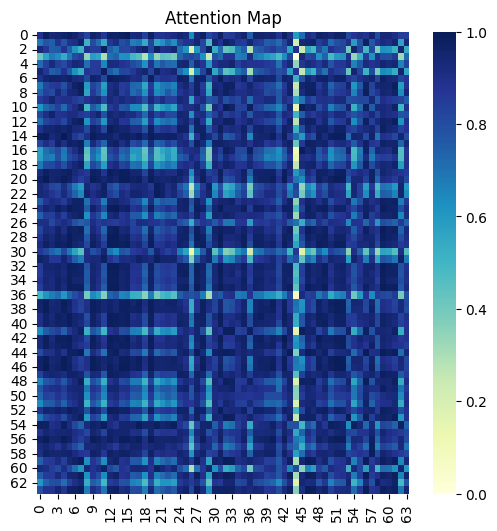

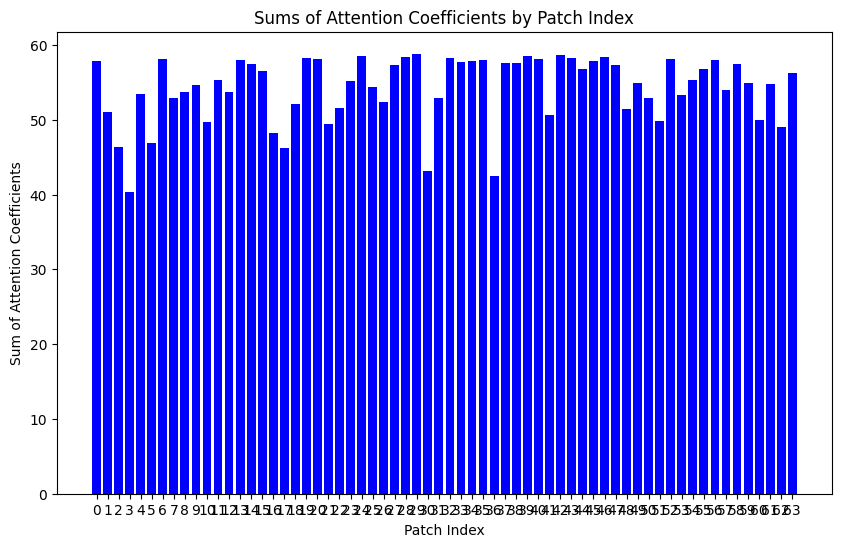

tensor([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▏         | 1/50 [23:57<19:33:40, 1437.15s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.940506 50.87829  46.92093  40.05451  53.72316  46.559433 58.17973
 52.693573 54.170685 54.901764 49.729385 55.372643 53.445198 58.072926
 57.64598  56.699524 48.608246 46.607605 52.16256  58.43289  58.189026
 49.101494 51.582676 55.27775  58.43521  54.19809  52.093353 57.466087
 58.542538 58.81584  42.91535  53.254875 58.29264  57.861263 57.7786
 58.061607 42.680595 57.62558  57.54248  58.522648 58.183994 50.06513
 58.72697  58.281517 57.014954 57.863823 58.434658 57.27129  51.133617
 55.26233  53.216423 49.664047 58.256577 53.167915 55.423695 56.74812
 58.07646  53.795307 57.51533  55.07815  49.424984 54.81866  49.466263
 56.0726  ]


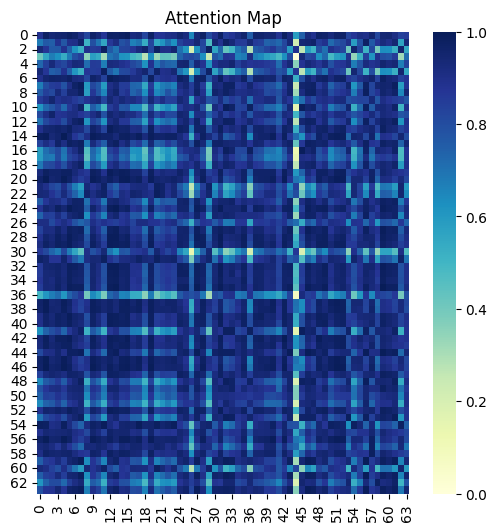

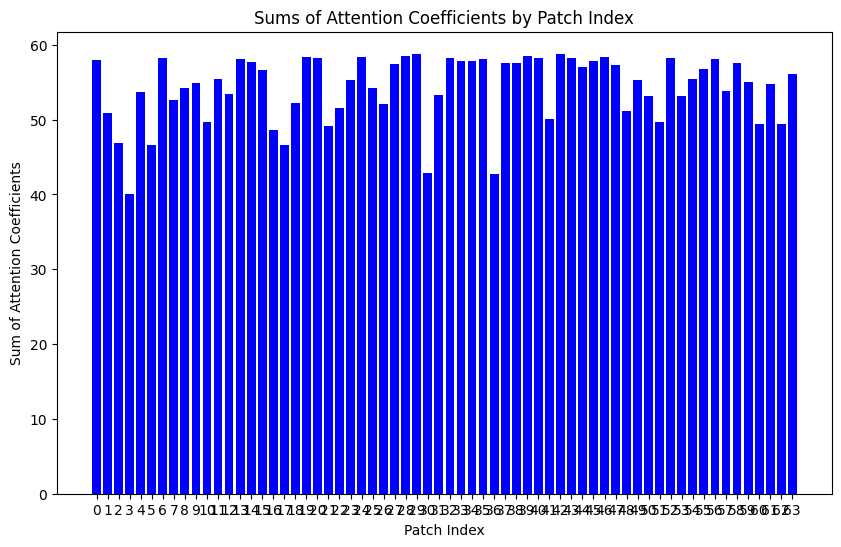

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  4%|▍         | 2/50 [50:58<20:36:11, 1545.24s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.917564 50.42344  46.664078 39.9817   53.790848 47.160175 58.075813
 52.32523  54.389847 54.88208  49.988876 55.242783 53.05506  57.988083
 57.64029  56.778633 48.174023 46.89731  52.287506 58.499107 58.33677
 48.847034 51.468407 55.07191  58.2508   53.75721  52.45327  57.499485
 58.61451  58.743435 42.93129  53.7265   58.311287 57.861763 57.85844
 58.07759  42.019512 57.833557 57.753593 58.561295 58.12219  49.315025
 58.79555  58.354828 56.74247  57.82695  58.45908  57.15983  50.71025
 54.915844 53.380833 49.216976 58.286186 52.703735 55.289978 56.670563
 58.280975 53.707474 57.541786 54.87805  49.270782 54.97469  49.012886
 55.7411  ]


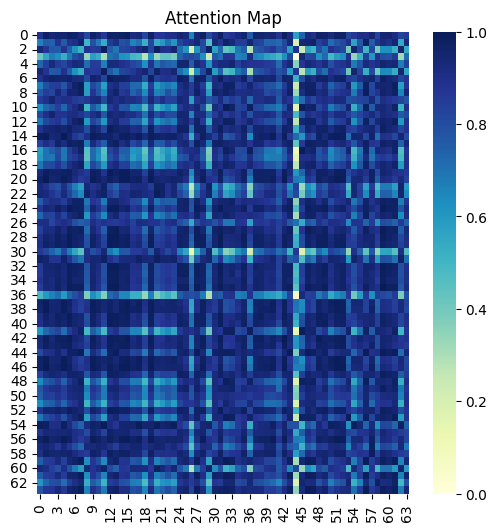

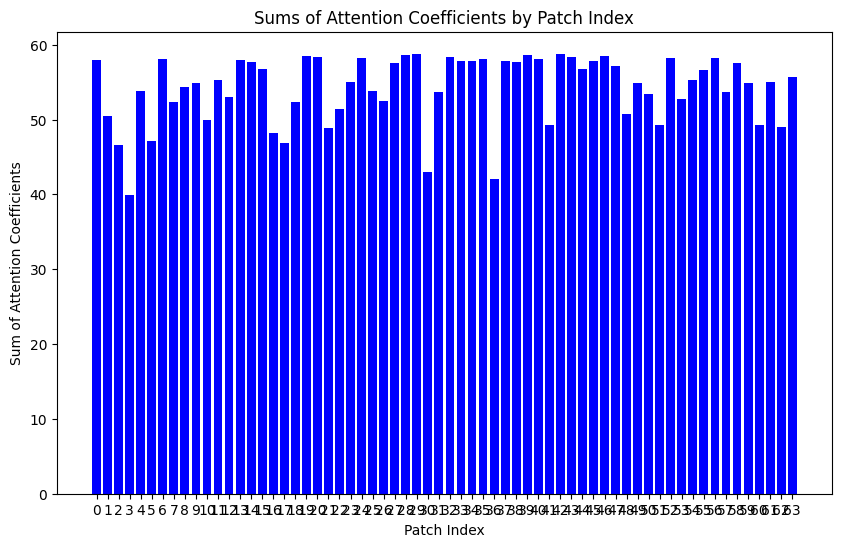

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  6%|▌         | 3/50 [1:18:26<20:47:14, 1592.23s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.89322  49.963    46.423035 39.970047 53.892563 47.757526 57.964752
 51.9719   54.640038 54.83812  50.295296 55.09243  52.65905  57.89319
 57.682922 56.8904   47.734055 47.232586 52.444374 58.568382 58.45237
 48.611877 51.396942 54.868088 58.043713 53.28462  52.815754 57.555023
 58.698746 58.645016 42.958084 54.032322 58.35023  57.879593 57.960396
 58.106937 41.366425 58.04175  57.871574 58.615685 58.04662  48.558437
 58.861435 58.35402  56.444504 57.808533 58.546764 57.054512 50.3217
 54.531857 53.577103 48.80058  58.328846 52.268078 55.212997 56.578556
 58.405243 53.641647 57.54486  54.674034 49.615513 55.17414  48.56252
 55.379204]


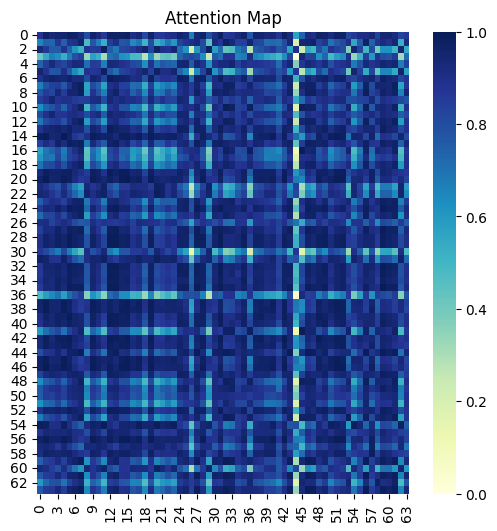

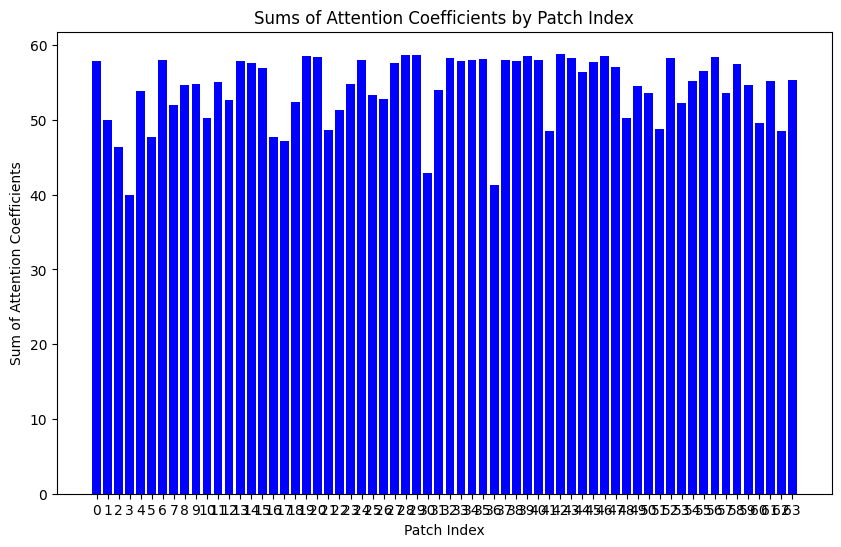

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  8%|▊         | 4/50 [1:46:38<20:51:02, 1631.78s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.87288  49.447968 46.180336 39.93029  53.934387 48.373672 57.848503
 51.61206  54.827248 54.777172 50.557034 54.929695 52.262085 57.78293
 57.732437 56.981945 47.242558 47.3419   52.565094 58.65516  58.603397
 48.477924 51.313244 54.639244 57.81599  52.74371  53.172848 57.52703
 58.778908 58.53965  42.99247  54.394314 58.384323 57.888874 58.04153
 58.126804 40.615005 58.25575  58.039154 58.65192  57.956436 47.726704
 58.931545 58.381886 56.118336 57.797302 58.634586 56.944313 49.916916
 54.084908 53.639206 48.325356 58.362846 51.788982 55.13626  56.471725
 58.57518  53.59188  57.582092 54.420273 49.99767  55.283707 48.040764
 55.013763]


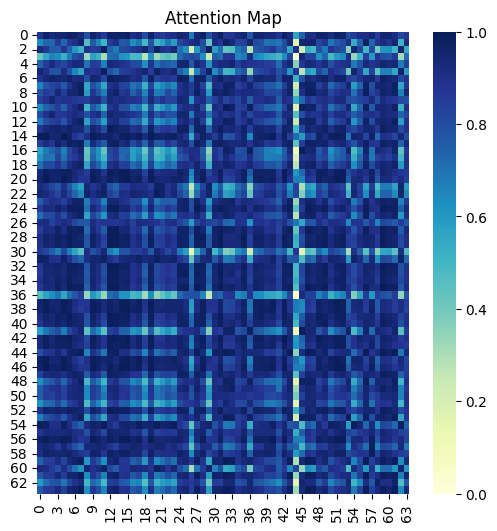

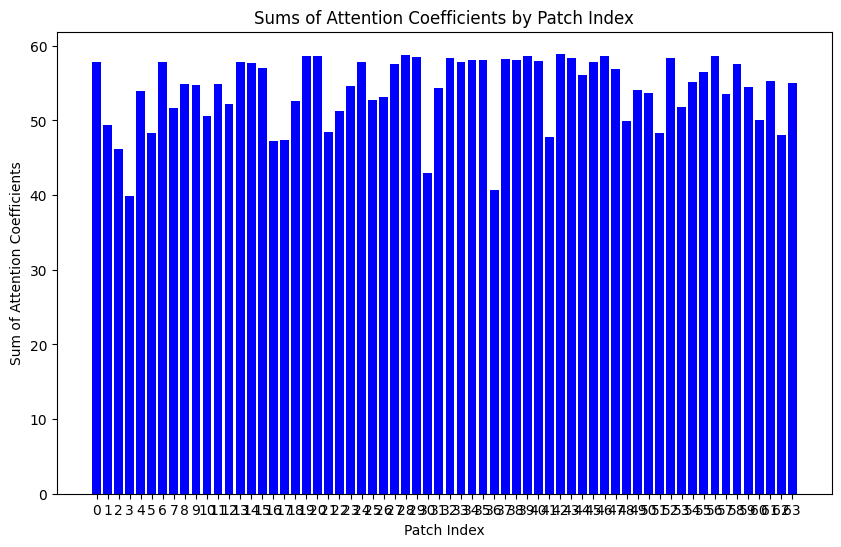

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 10%|█         | 5/50 [2:14:39<20:37:11, 1649.59s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.853996 48.89     45.932117 39.887634 53.945675 48.995255 57.72265
 51.247894 54.982002 54.687916 50.810852 54.746113 51.85834  57.654694
 57.78722  57.07154  46.713993 47.370686 52.674088 58.750244 58.75907
 48.34171  51.216843 54.391098 57.560898 52.14823  53.51633  57.45295
 58.85853  58.416927 43.034622 54.76802  58.419495 57.897556 58.11651
 58.14468  39.81041  58.463593 58.212925 58.684227 57.849068 46.831825
 58.995476 58.420113 55.764637 57.792305 58.72499  56.82817  49.524185
 53.585953 53.652344 47.812485 58.3945   51.28441  55.06165  56.34487
 58.7538   53.55299  57.630623 54.12452  50.391747 55.3363   47.46767
 54.634003]


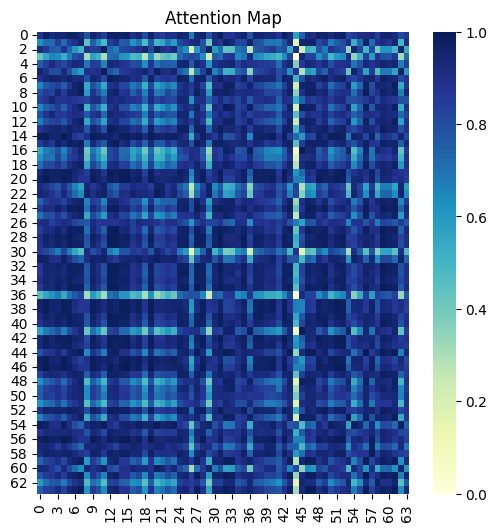

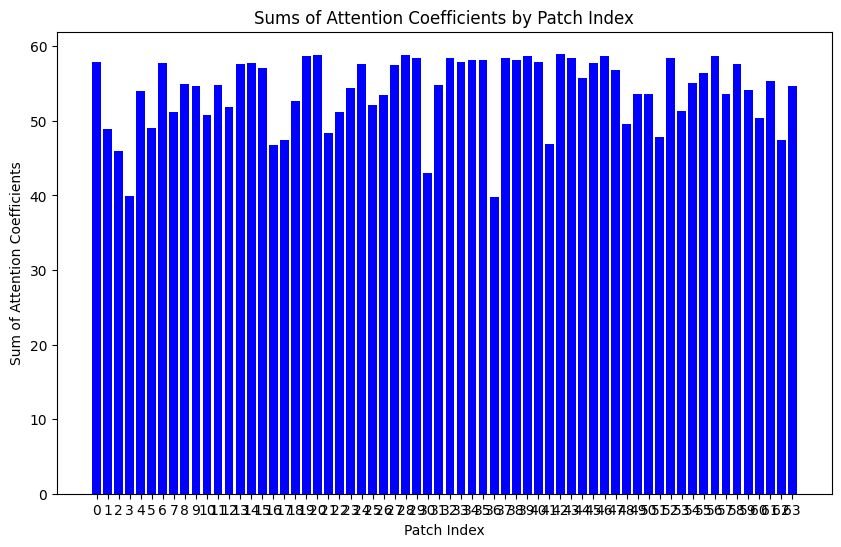

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 12%|█▏        | 6/50 [2:43:04<20:23:27, 1668.35s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.746635 48.205345 45.60325  39.782177 53.856266 49.54675  57.495876
 50.790977 55.02997  54.47865  50.98554  54.44648  51.35603  57.416237
 57.759804 57.078148 46.070698 47.2834   52.697807 58.7602   58.82257
 48.126324 51.026276 54.0366   57.18232  51.417652 53.761696 57.252518
 58.851196 58.17725  43.013985 55.05839  58.36902  57.819183 58.101288
 58.0739   38.90266  58.569748 58.293907 58.626198 57.631516 45.78556
 58.95951  58.374916 55.287514 57.70754  58.72886  56.614883 49.065186
 52.953438 53.546688 47.181316 58.336487 50.671234 54.90498  56.10895
 58.840786 53.44521  57.597576 53.700447 50.711967 55.24736  46.767426
 54.142776]


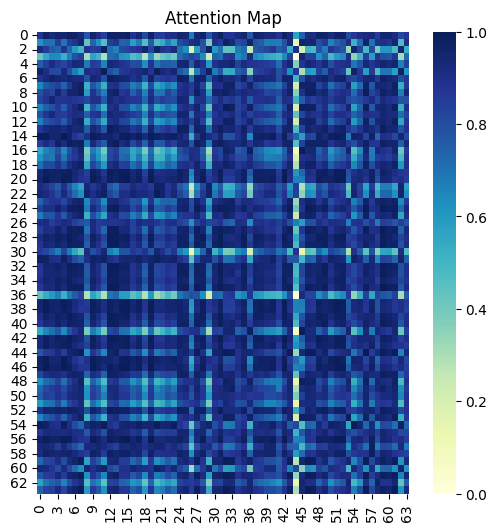

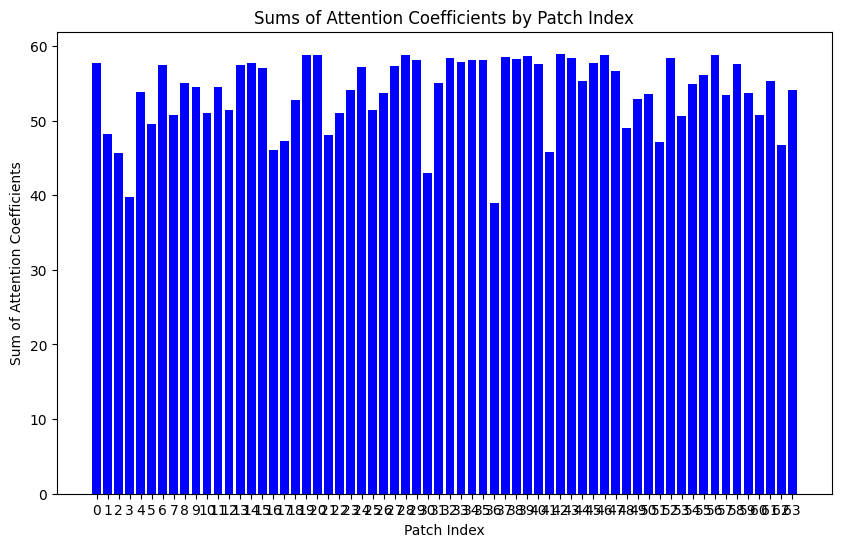

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 14%|█▍        | 7/50 [3:11:42<20:07:23, 1684.72s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.68399  47.567696 45.378983 39.827003 53.828842 50.19895  57.304695
 50.398567 55.123993 54.294754 51.247627 54.168556 50.91191  57.20287
 57.7843   57.14434  45.50064  47.2927   52.797894 58.81351  58.920296
 48.00724  50.902016 53.730545 56.8122   50.723038 54.056202 57.06978
 58.889008 57.94161  43.125423 55.406937 58.367203 57.790833 58.130722
 58.049427 38.156593 58.700027 58.41051  58.61197  57.434505 44.77198
 58.951656 58.375546 54.824707 57.679962 58.77425  56.441868 48.70904
 52.35637  53.48182  46.607822 58.322773 50.114037 54.809837 55.90557
 58.961105 53.423668 57.619175 53.301857 51.097694 55.154278 46.127808
 53.68242 ]


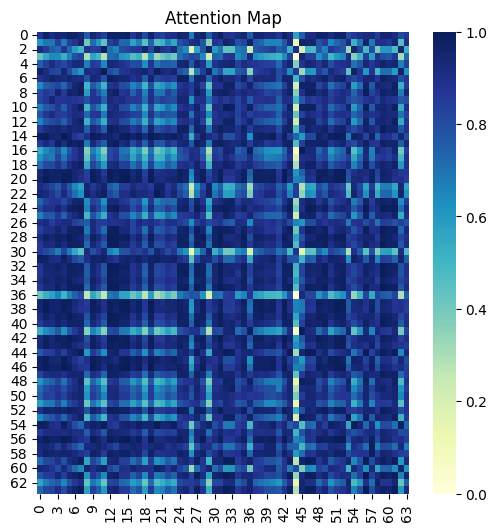

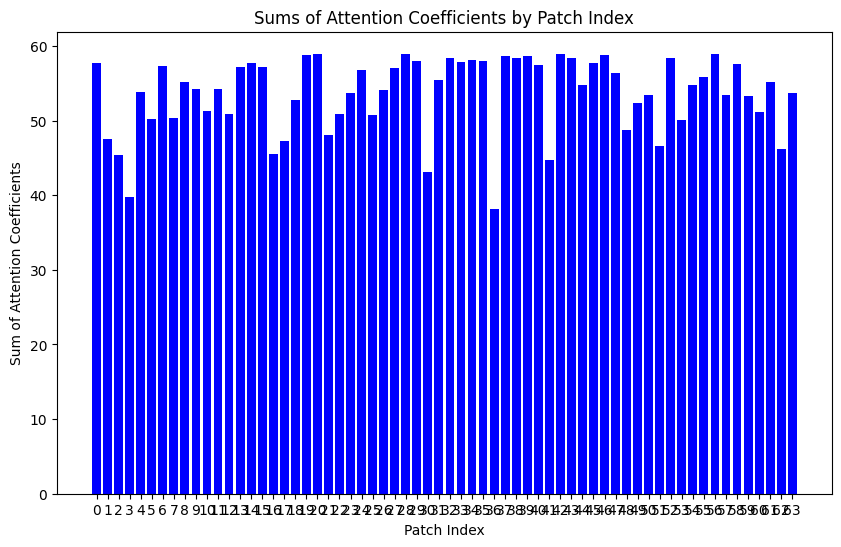

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 16%|█▌        | 8/50 [3:40:51<19:53:31, 1705.03s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.655502 46.970093 45.224533 39.984398 53.855873 50.91912  57.143867
 50.048492 55.263474 54.125195 51.575436 53.898407 50.513115 57.010303
 57.848526 57.270844 44.9926   47.411537 52.959015 58.90039  59.0402
 47.95994  50.82303  53.471207 56.443966 50.06292  54.374775 56.93505
 58.96402  57.69876  43.32296  55.791145 58.40867  57.809616 58.195087
 58.06629  37.69553  58.84115  58.5503   58.637234 57.250465 43.797073
 58.96828  58.409653 54.374687 57.699013 58.847923 56.302086 48.43354
 51.80422  53.457497 46.078026 58.34887  49.61095  54.75399  55.723995
 59.101215 53.47561  57.688675 52.92681  51.451447 55.044186 45.544548
 53.244217]


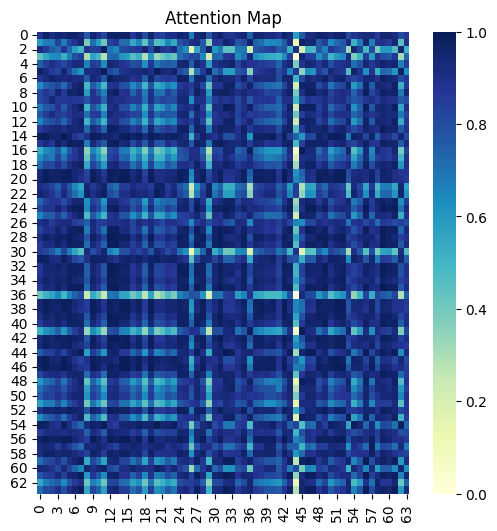

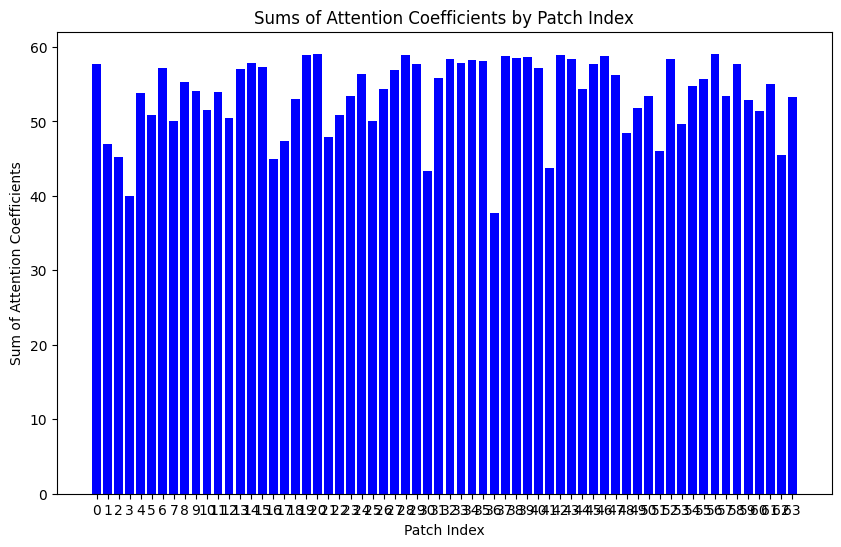

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 18%|█▊        | 9/50 [4:10:56<19:46:22, 1736.15s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.545845 46.22293  44.877625 39.992184 53.7676   51.502373 56.895493
 49.5654   55.335297 53.826767 51.809822 53.502205 50.00184  56.724705
 57.832283 57.340645 44.335793 47.45228  53.03186  58.917686 59.076897
 47.768745 50.592842 53.117905 55.9646   49.263138 54.568695 56.838394
 58.97519  57.357185 43.326843 56.063206 58.392296 57.76924  58.18379
 58.025475 37.406418 58.888645 58.60144  58.607048 56.972137 42.643528
 58.930542 58.366013 53.815163 57.6406   58.843723 56.07743  48.043076
 51.134987 53.327393 45.40016  58.315956 48.98248  54.57923  55.433777
 59.153557 53.435425 57.68854  52.434776 51.474808 54.7881   44.80879
 52.686142]


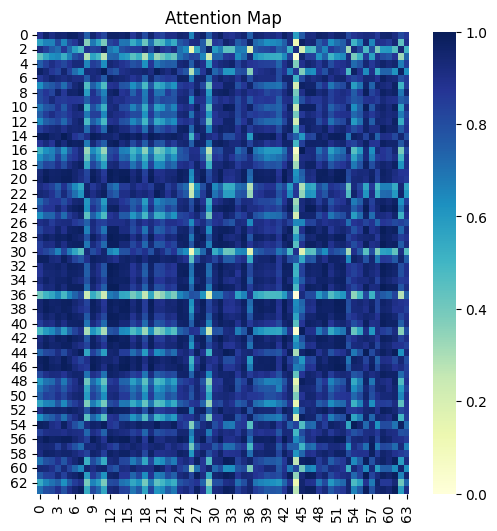

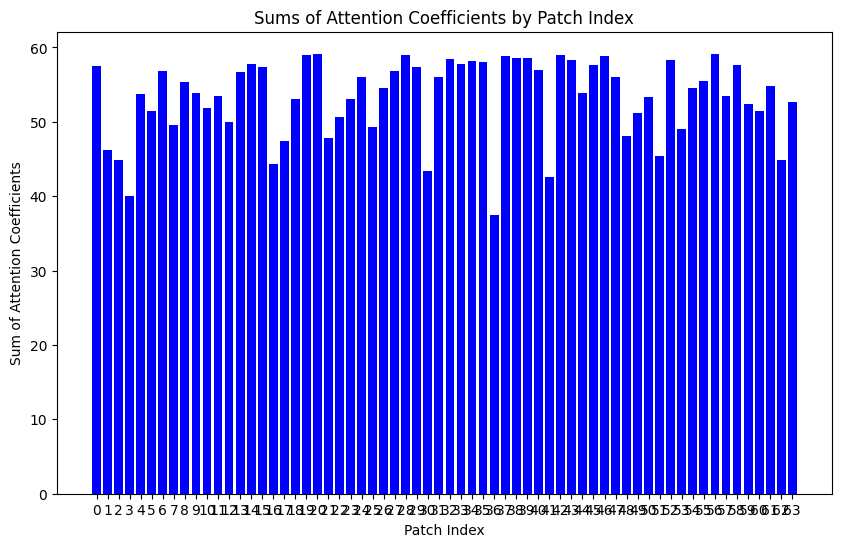

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 20%|██        | 10/50 [4:41:42<19:40:10, 1770.27s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.413055 45.501022 44.437256 40.068634 53.623028 51.83145  56.629383
 49.132313 55.44362  53.495018 52.06835  53.093964 49.533577 56.41501
 57.764423 57.416103 43.722404 47.580513 53.15204  58.916138 59.074947
 47.4937   50.27627  52.78649  55.490784 48.493137 54.70066  56.82297
 58.975    56.986504 43.270847 56.164635 58.384247 57.738544 58.14707
 57.99408  37.410416 58.888565 58.585926 58.598915 56.68266  41.5745
 58.915573 58.29396  53.265633 57.569695 58.823803 55.85649  47.682888
 50.471977 53.29082  44.754066 58.29764  48.539814 54.37564  55.13331
 59.16503  53.29598  57.672775 51.95585  51.36057  54.516495 44.115105
 52.1553  ]


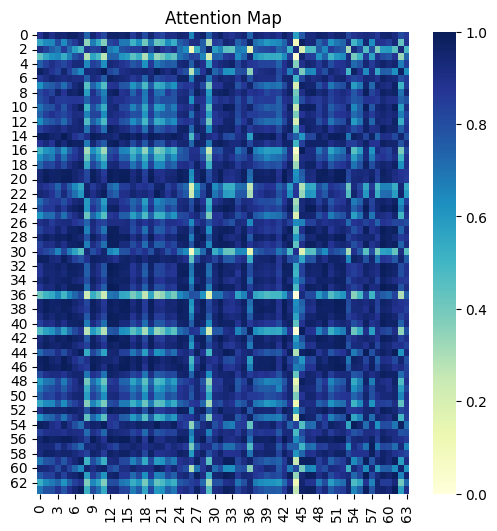

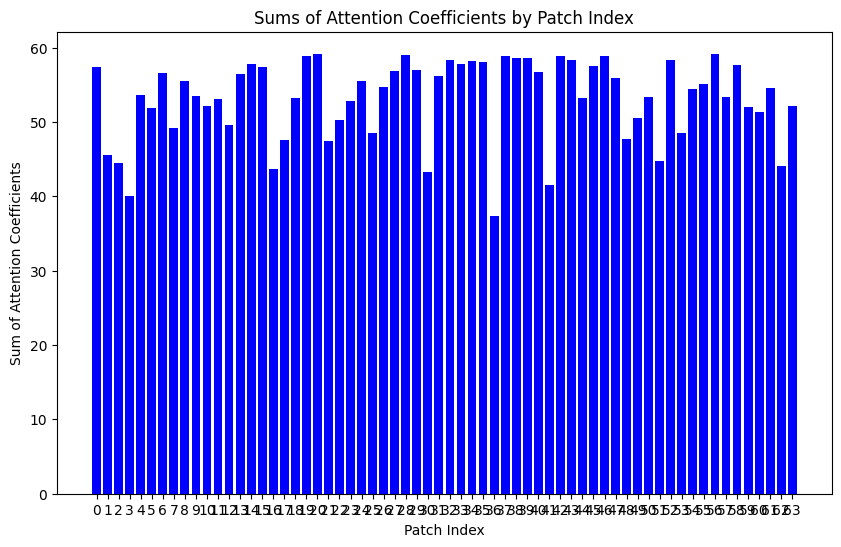

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 22%|██▏       | 11/50 [5:12:31<19:26:21, 1794.39s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.284428 44.87113  43.93026  39.99878  53.608826 51.94935  56.375214
 48.786934 55.595566 53.17074  52.2462   52.71465  49.12855  56.103973
 57.66593  57.45324  43.224564 47.659348 53.32702  58.912853 59.060173
 47.080223 49.89666  52.523724 55.075935 47.789055 54.79126  56.83303
 58.98032  56.65716  43.144188 56.143345 58.398743 57.732967 58.093132
 57.993275 37.56737  58.870285 58.546017 58.615643 56.41571  41.05497
 58.92431  58.202164 52.780357 57.543045 58.828682 55.675278 47.3702
 50.105907 53.373688 44.597214 58.29783  48.48001  54.33612  54.874348
 59.14234  53.100918 57.648743 51.601227 51.51782  54.451843 43.639458
 51.6945  ]


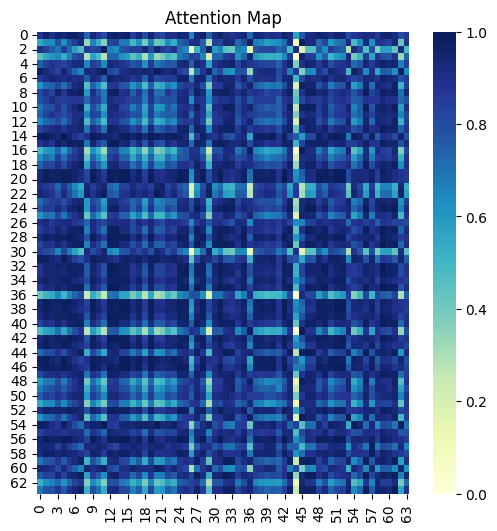

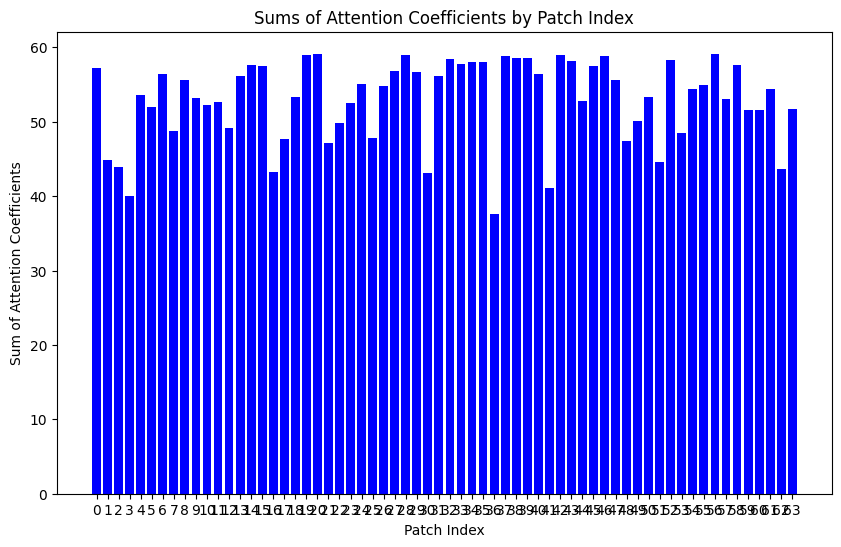

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 24%|██▍       | 12/50 [5:43:08<19:04:39, 1807.37s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.18522  44.34496  43.489677 39.8832   53.713245 52.008076 56.15583
 48.533676 55.80021  52.886105 52.366047 52.374012 48.794075 55.808502
 57.586823 57.548782 42.848053 47.60205  53.561832 58.938232 59.070885
 46.69359  49.54169  52.3348   54.698845 47.17428  54.899216 56.83128
 59.011147 56.345093 43.07106  56.105965 58.452255 57.773575 58.042526
 58.030556 37.68653  58.877396 58.52539  58.671753 56.19041  40.98639
 58.972557 58.123817 52.371548 57.58784  58.873245 55.547443 47.102642
 50.043137 53.57228  44.69047  58.340492 48.647064 54.45424  54.690628
 59.138115 52.92849  57.656204 51.39868  51.841095 54.592163 43.39659
 51.268066]


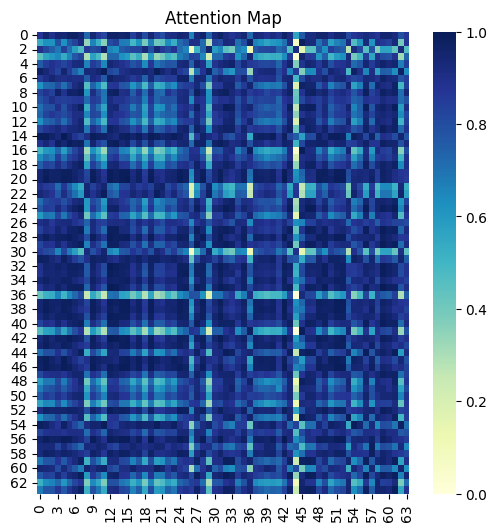

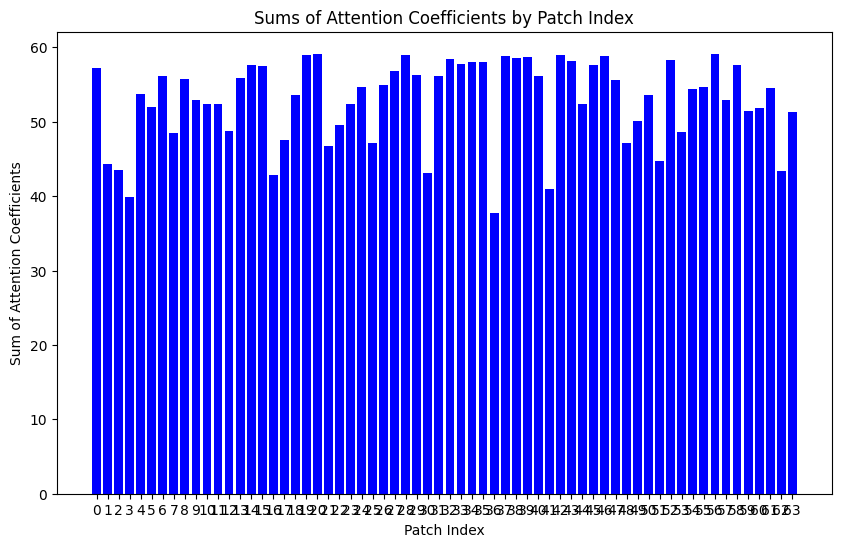

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 26%|██▌       | 13/50 [6:13:58<18:42:24, 1820.13s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [57.089363 43.87339  43.103813 39.74365  53.86816  52.024384 55.94711
 48.330826 56.023712 52.609184 52.40605  52.035404 48.491985 55.510765
 57.519417 57.671463 42.53197  47.483284 53.800636 58.974663 59.09371
 46.3161   49.21443  52.17622  54.32023  46.59818  55.01243  56.818073
 59.045673 56.02346  43.019672 56.05733  58.520233 57.833824 57.970085
 58.079395 37.780373 58.89504  58.509377 58.737648 56.012413 41.187233
 59.03115  58.040207 52.02825  57.666832 58.928864 55.458527 46.888084
 50.15754  53.824944 44.88849  58.401566 48.92782  54.652603 54.55532
 59.143604 52.765404 57.680267 51.286377 52.229256 54.803955 43.32681
 50.837986]


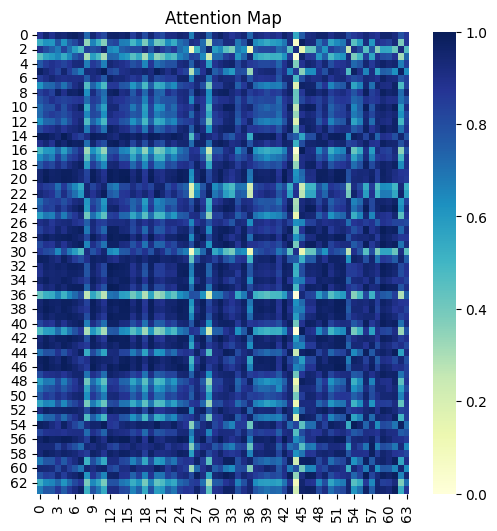

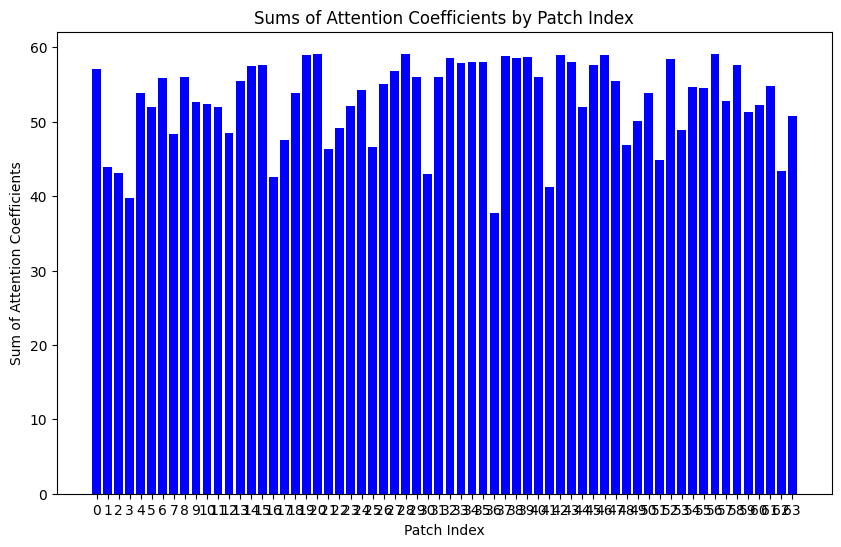

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 28%|██▊       | 14/50 [6:44:04<18:09:27, 1815.76s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.98642  43.427586 42.796318 39.597786 54.028027 52.080086 55.730965
 48.15587  56.23787  52.319336 52.414467 51.684723 48.22766  55.21659
 57.469772 57.79593  42.23646  47.380806 54.018555 59.006626 59.11798
 45.97306  48.921974 52.01686  53.941315 46.024635 55.128025 56.777733
 59.06821  55.68545  43.004932 56.043457 58.577866 57.884933 57.869923
 58.107548 37.802383 58.91176  58.496475 58.788906 55.834717 41.433784
 59.076843 57.963337 51.69484  57.745705 58.97616  55.376232 46.682068
 50.31248  54.060417 45.069725 58.45603  49.22056  54.865993 54.421516
 59.154827 52.65798  57.714558 51.197838 52.602818 54.978817 43.31086
 50.39499 ]


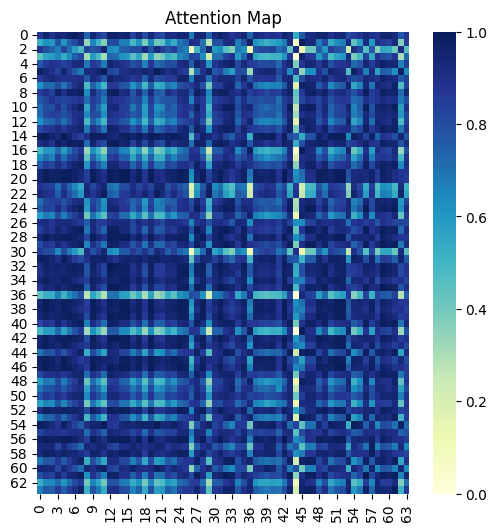

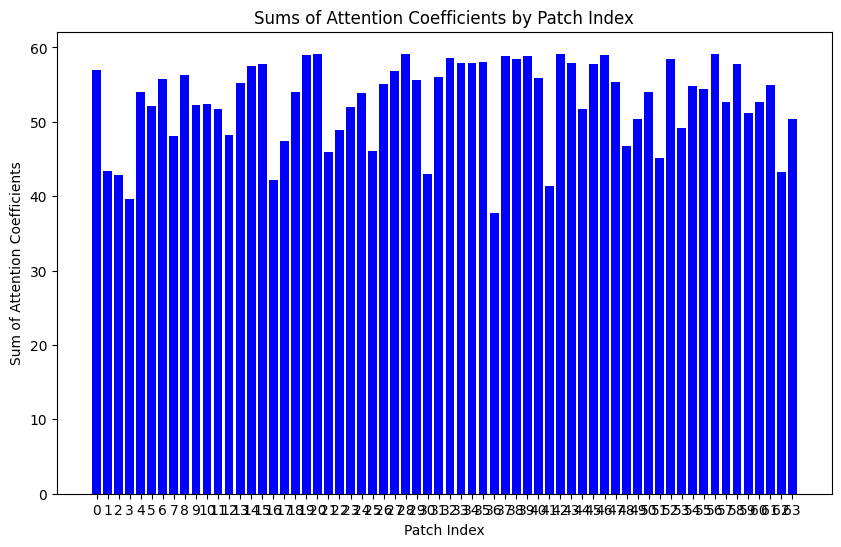

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 30%|███       | 15/50 [7:14:46<17:43:56, 1823.91s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.87742  42.997627 42.56681  39.452713 54.188675 52.21798  55.50458
 48.002884 56.437675 52.014435 52.425438 51.326763 48.015816 54.93087
 57.446507 57.913124 41.954506 47.32897  54.218235 59.030846 59.14068
 45.678738 48.656796 51.85382  53.57022  45.442944 55.249832 56.706596
 59.080433 55.329002 43.03103  56.084984 58.621113 57.921738 57.754753
 58.110283 37.74214  58.926254 58.490906 58.825798 55.631973 41.611916
 59.109318 57.910286 51.34297  57.8134   59.01296  55.281067 46.467476
 50.430557 54.27056  45.213955 58.49904  49.486565 55.064476 54.265747
 59.17062  52.622    57.755703 51.108757 52.941643 55.088226 43.29617
 49.93824 ]


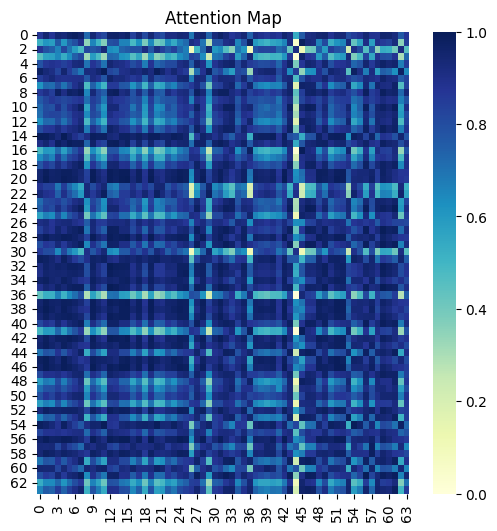

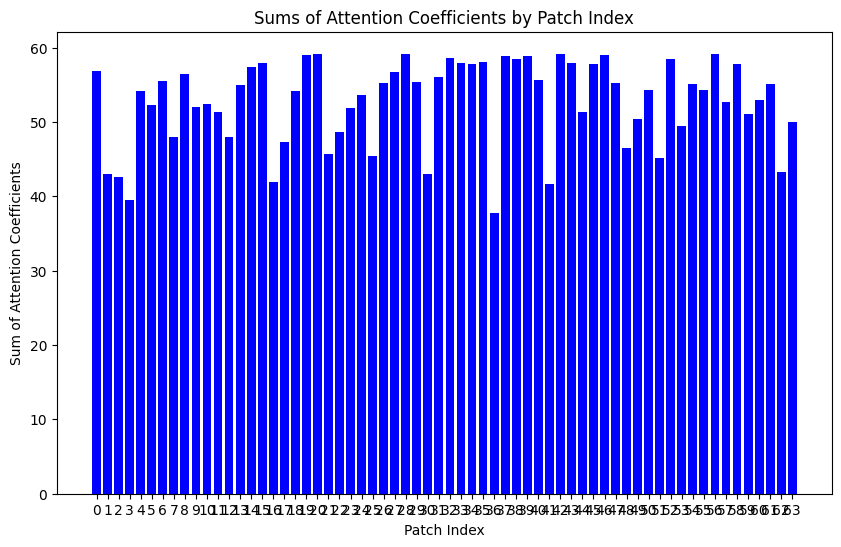

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 32%|███▏      | 16/50 [7:47:17<17:35:14, 1862.19s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.759464 42.565952 42.38064  39.2893   54.341614 52.415672 55.2601
 47.85265  56.617878 51.6865   52.440887 50.954353 47.842426 54.64281
 57.44291  58.002205 41.666695 47.34108  54.394836 59.04062  59.153694
 45.4098   48.39385  51.678066 53.20529  44.844467 55.368378 56.610054
 59.08195  54.949436 43.068512 56.166397 58.64611  57.94046  57.6326
 58.089874 37.648354 58.93164  58.485886 58.84683  55.39485  41.665268
 59.126026 57.87371  50.956863 57.861443 59.032112 55.159462 46.240913
 50.45167  54.45227  45.317223 58.525696 49.706284 55.22237  54.070976
 59.182705 52.63951  57.793236 50.99415  53.235962 55.109528 43.245335
 49.458908]


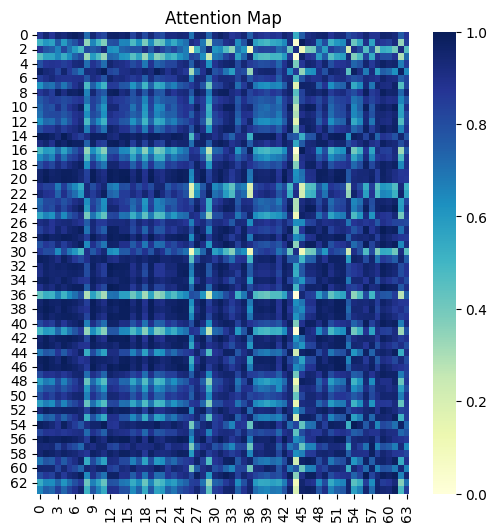

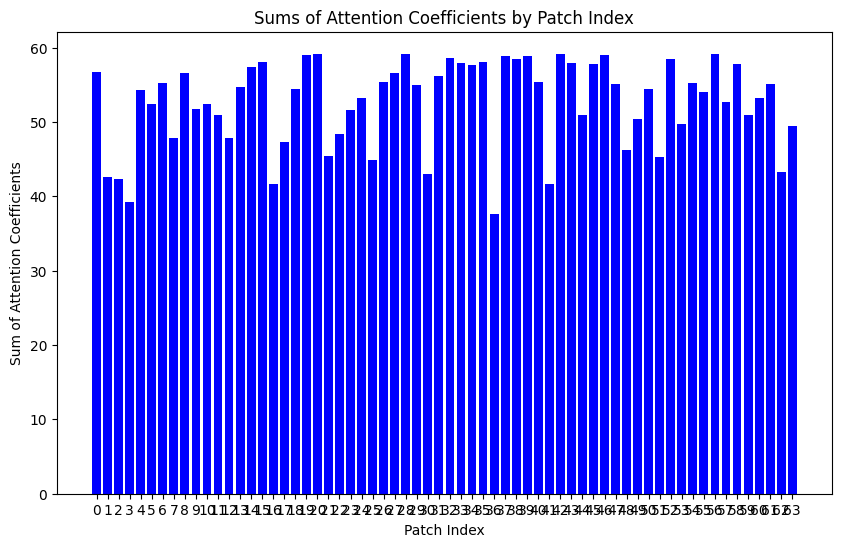

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 34%|███▍      | 17/50 [8:20:13<17:23:00, 1896.39s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.618027 42.074135 42.161434 39.04859  54.45535  52.59382  54.97142
 47.64751  56.76353  51.31169  52.437637 50.536957 47.64208  54.31217
 57.411613 58.012253 41.31822  47.39988  54.533543 59.020897 59.140495
 45.11518  48.073135 51.456184 52.830505 44.21707  55.45938  56.537037
 59.063534 54.549828 43.064373 56.235817 58.640743 57.92825  57.51401
 58.046272 37.625023 58.91246  58.45977  58.84048  55.098698 41.50879
 59.115444 57.827026 50.50573  57.869873 59.01751  54.985703 45.975685
 50.303047 54.576153 45.33309  58.52129  49.82962  55.28899  53.80732
 59.173653 52.64808  57.805504 50.79146  53.4274   54.991043 43.077263
 48.954727]


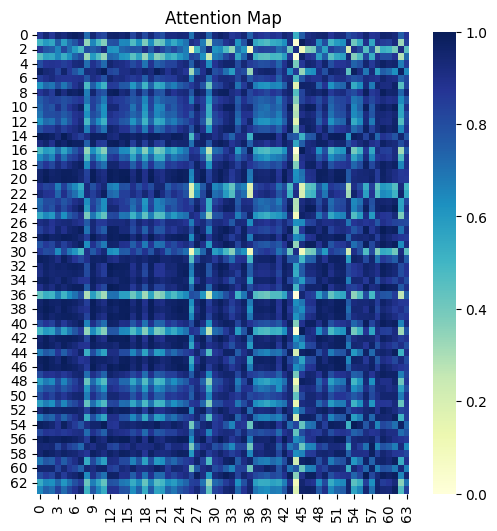

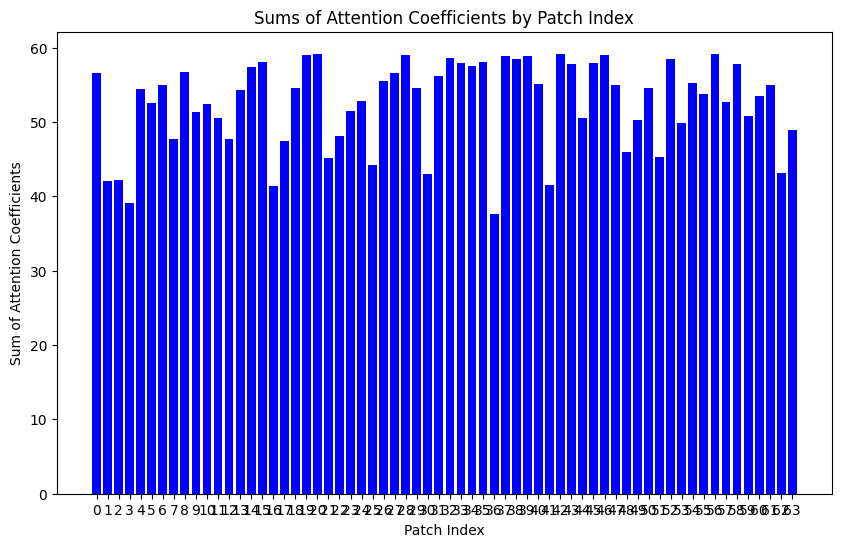

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 36%|███▌      | 18/50 [8:50:48<16:41:34, 1877.97s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.444145 41.484325 41.87796  38.71528  54.502876 52.708923 54.623917
 47.35376  56.87259  50.879646 52.421272 50.055027 47.36346  53.90511
 57.329067 57.953465 40.88772  47.483757 54.6344   58.96759  59.095467
 44.783493 47.6616   51.169872 52.43591  43.57631  55.514595 56.5047
 59.022034 54.15786  43.0138   56.26634  58.601818 57.881725 57.426624
 57.9834   37.694553 58.86442  58.404404 58.80349  54.73442  41.08158
 59.074528 57.763134 49.972023 57.832237 58.964592 54.74434  45.637535
 49.973595 54.61682  45.21617  58.480858 49.82375  55.24151  53.462154
 59.13694  52.604416 57.784286 50.46707  53.466827 54.71734  42.742477
 48.452194]


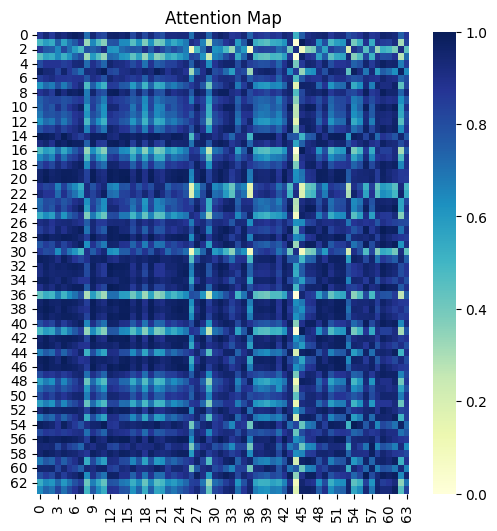

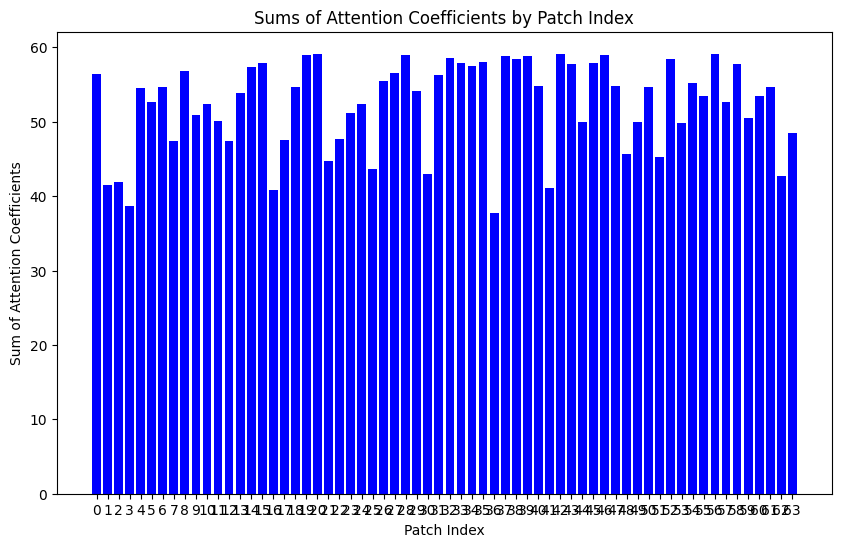

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 38%|███▊      | 19/50 [9:21:16<16:02:24, 1862.72s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.307606 40.990875 41.723045 38.511467 54.56694  52.863815 54.29827
 47.118122 57.00886  50.503433 52.490936 49.626263 47.145615 53.50612
 57.253784 57.895096 40.577213 47.71293  54.778244 58.92672  59.0628
 44.584496 47.305405 50.927612 52.12867  43.098896 55.607903 56.544487
 59.00181  53.865303 43.103386 56.326416 58.57778  57.855194 57.42651
 57.95227  38.00943  58.834244 58.3712   58.783077 54.37852  40.60587
 59.047768 57.738487 49.478165 57.806114 58.91958  54.5158   45.380863
 49.614834 54.65258  45.12863  58.45312  49.817528 55.17047  53.13031
 59.11489  52.613125 57.78482  50.147827 53.465343 54.390656 42.439095
 48.09254 ]


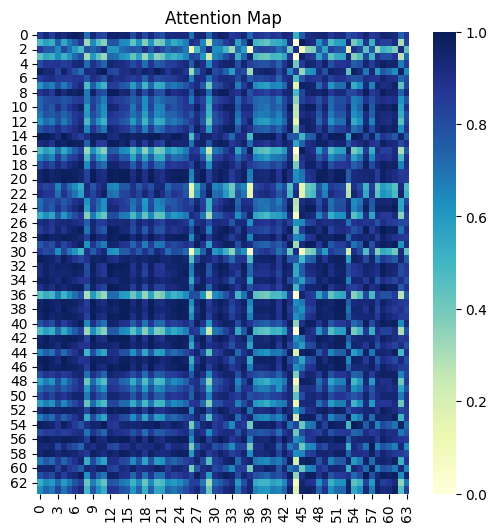

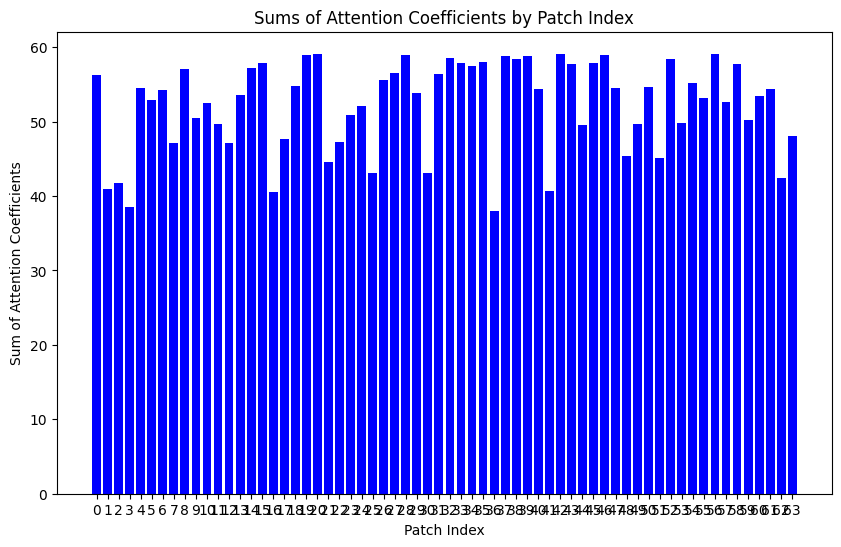

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 40%|████      | 20/50 [9:52:39<15:34:28, 1868.96s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.181305 40.507256 41.60055  38.314026 54.622543 53.019623 53.95403
 46.880795 57.13763  50.124172 52.56832  49.191612 46.93474  53.083973
 57.165108 57.81697  40.28342  47.991463 54.916824 58.874504 59.019535
 44.4301   46.945488 50.67218  51.855526 42.673683 55.697353 56.599106
 58.977425 53.606194 43.227306 56.38465  58.54336  57.819565 57.4563
 57.91838  38.403706 58.79723  58.335136 58.75512  53.98953  40.05556
 59.011887 57.720673 48.97144  57.767654 58.85969  54.264732 45.13713
 49.20354  54.652695 45.017323 58.41154  49.783028 55.063038 52.773827
 59.082565 52.64951  57.777763 49.795082 53.415672 53.990215 42.11573
 47.773903]


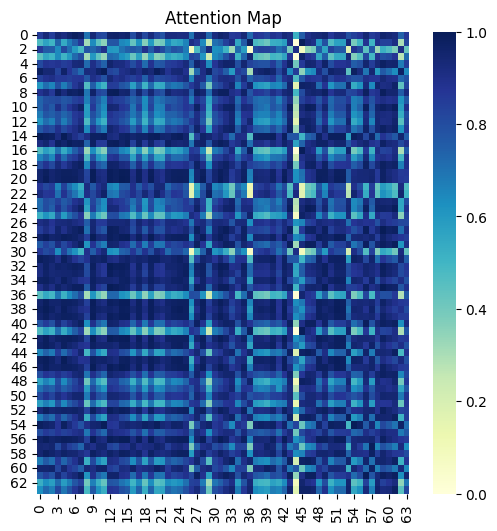

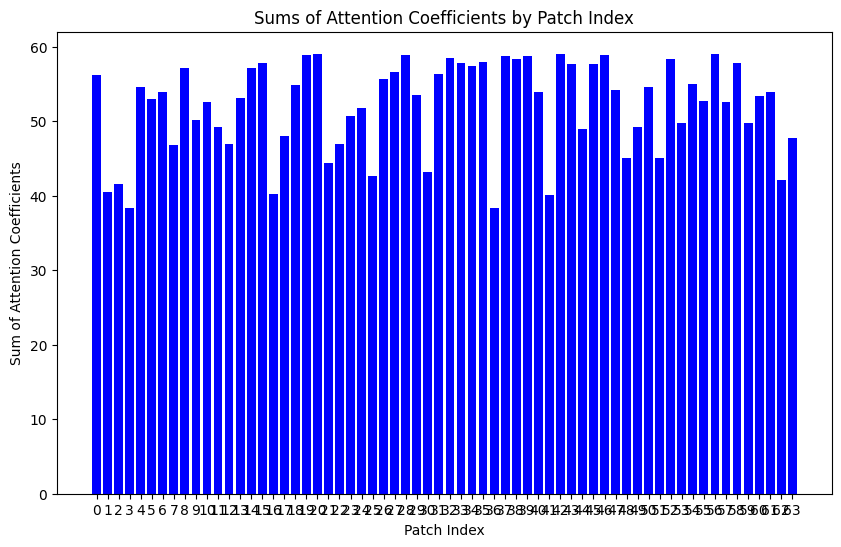

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 42%|████▏     | 21/50 [10:23:24<14:59:46, 1861.60s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [56.058533 40.064346 41.528053 38.117252 54.689262 53.18656  53.5951
 46.669083 57.253483 49.747314 52.612022 48.760826 46.772205 52.670982
 57.086105 57.73039  40.017525 48.29873  55.04337  58.80558  58.960472
 44.316658 46.625595 50.411163 51.5775   42.261406 55.777313 56.63395
 58.94017  53.33049  43.373573 56.44442  58.495213 57.772255 57.478333
 57.86681  38.828934 58.74633  58.291412 58.71484  53.581543 39.591988
 58.961697 57.698254 48.480076 57.72328  58.78131  54.02482  44.90029
 48.823063 54.651443 44.948006 58.35299  49.793434 54.96333  52.415207
 59.032402 52.740623 57.75982  49.46736  53.38453  53.55805  41.857086
 47.43818 ]


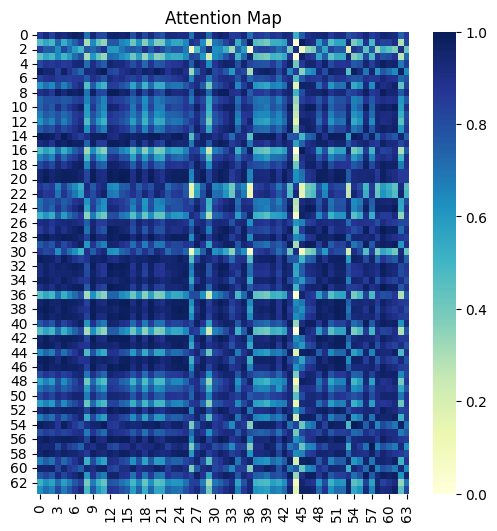

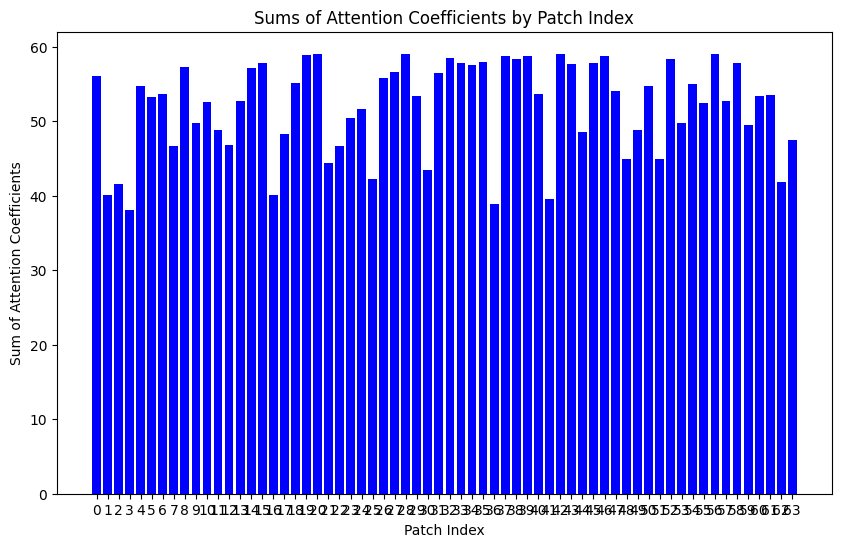

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 44%|████▍     | 22/50 [10:55:17<14:36:02, 1877.24s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [55.90758  39.66258  41.49713  37.88797  54.769646 53.3294   53.218044
 46.477493 57.34474  49.36268  52.56978  48.321167 46.64771  52.279305
 57.024086 57.643124 39.77551  48.580208 55.147453 58.71033  58.875996
 44.219124 46.35556  50.140198 51.231255 41.837868 55.833076 56.612896
 58.876606 52.99501  43.51702  56.49063  58.426094 57.71006  57.460594
 57.78088  39.185852 58.67022  58.227768 58.65171  53.175705 39.401546
 58.887398 57.65089  48.036148 57.674423 58.67926  53.846344 44.61284
 48.577393 54.6745   44.95849  58.27227  49.888153 54.90651  52.08619
 58.952873 52.86457  57.723774 49.230118 53.414112 53.163635 41.71769
 47.034225]


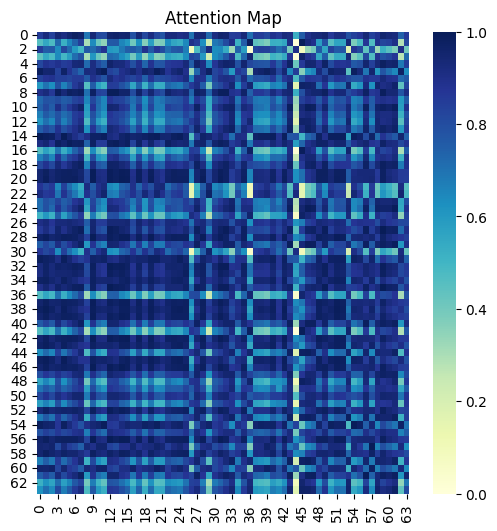

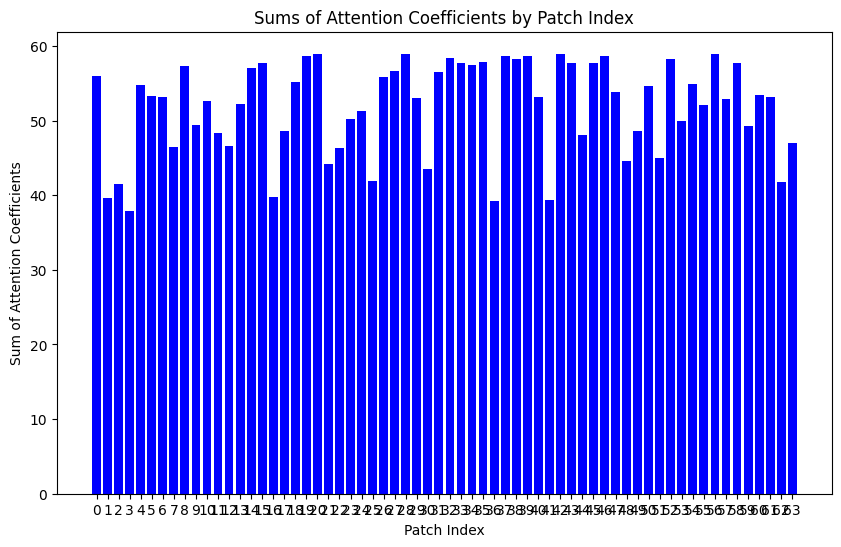

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 46%|████▌     | 23/50 [11:26:47<14:06:29, 1881.11s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [55.674904 39.259945 41.427284 37.57314  54.839214 53.33817  52.79321
 46.257515 57.38157  48.92811  52.37661  47.833702 46.449318 51.853607
 56.926113 57.529472 39.530033 48.746017 55.19832  58.561337 58.739716
 44.061012 46.061325 49.823784 50.78721  41.381622 55.8302   56.50756
 58.75682  52.573082 43.589413 56.459854 58.31092  57.610004 57.368927
 57.640007 39.42437  58.538338 58.10582  58.53418  52.790802 39.518005
 58.760612 57.529953 47.662575 57.59222  58.534706 53.715576 44.260796
 48.471577 54.710815 45.038986 58.14936  50.039925 54.872993 51.80263
 58.8162   52.932625 57.637924 49.077988 53.468292 52.837616 41.675316
 46.533592]


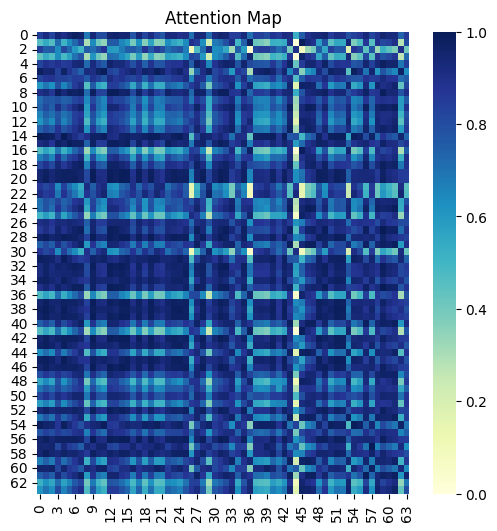

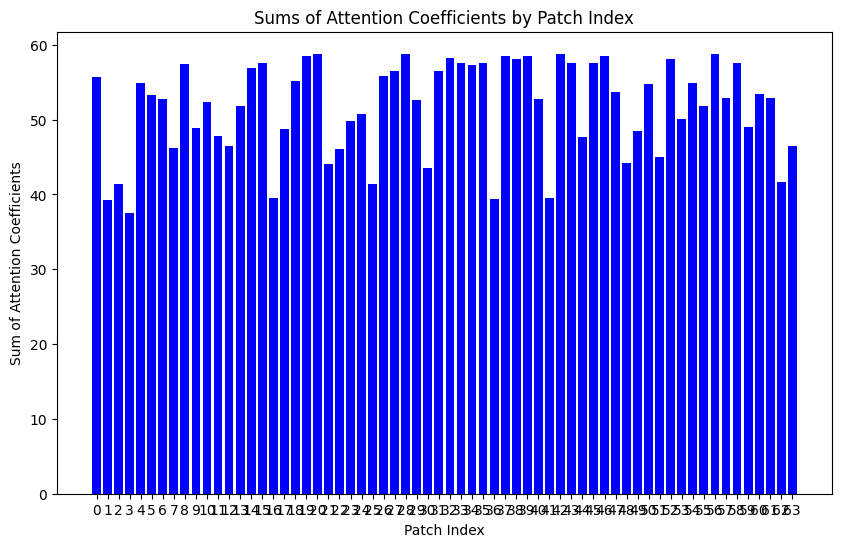

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 48%|████▊     | 24/50 [11:58:13<13:35:42, 1882.41s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [55.42349  38.92112  41.34555  37.26131  54.965992 53.23963  52.388233
 46.07627  57.430576 48.510986 52.10424  47.361153 46.196274 51.41294
 56.81898  57.451103 39.34783  48.82104  55.267273 58.429592 58.62589
 43.88424  45.7649   49.524605 50.336876 40.979717 55.83757  56.404133
 58.64869  52.151268 43.62735  56.38352  58.219437 57.536705 57.282825
 57.525894 39.689854 58.417557 57.982437 58.42526  52.55688  39.933388
 58.649986 57.39523  47.47115  57.536762 58.42108  53.677498 43.9362
 48.527954 54.817585 45.248596 58.05963  50.2994   54.914684 51.653534
 58.696053 52.930405 57.563904 49.061737 53.58111  52.646626 41.773735
 46.0259  ]


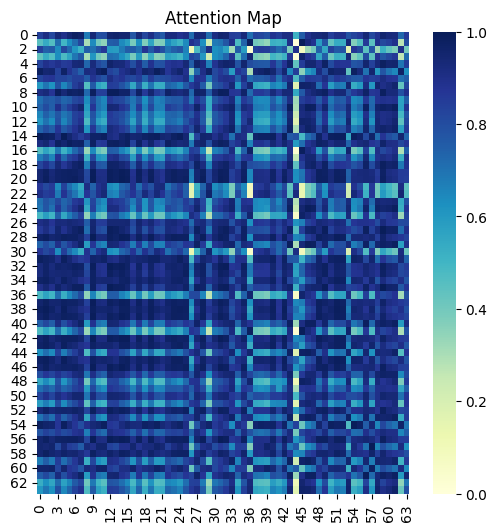

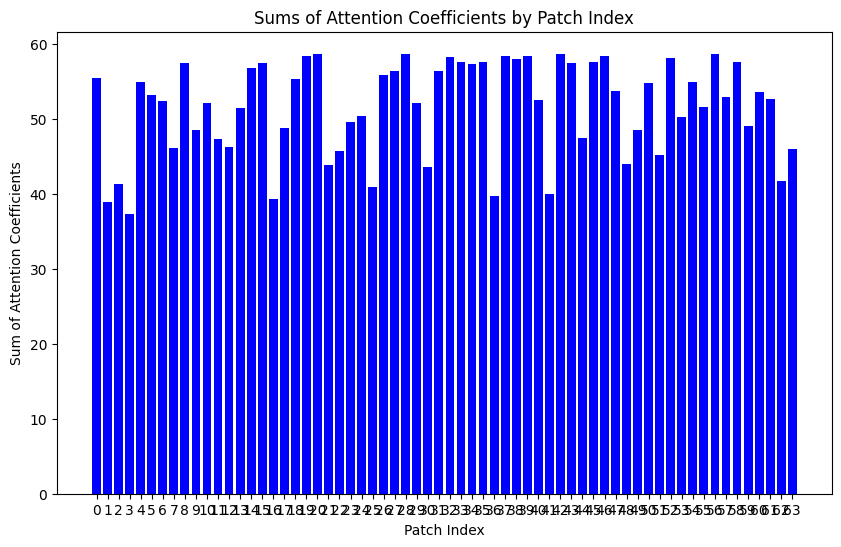

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 50%|█████     | 25/50 [12:30:11<13:08:47, 1893.10s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [55.222893 38.67708  41.306442 37.01126  55.20452  53.132526 52.06463
 45.98258  57.5578   48.166153 51.839035 46.94916  45.960556 51.00189
 56.753227 57.467854 39.253155 48.890106 55.42523  58.38765  58.60992
 43.752556 45.509113 49.293327 49.934555 40.69494  55.92749  56.40082
 58.624874 51.801548 43.69439  56.33379  58.22088  57.554016 57.29951
 57.520508 40.140675 58.381954 57.92917  58.39237  52.528095 40.58662
 58.627087 57.33105  47.484703 57.57343  58.40678  53.76677  43.684654
 48.727386 55.037445 45.602436 58.070713 50.693916 55.07553  51.687912
 58.670185 52.915695 57.569466 49.18948  53.77233  52.575844 42.00702
 45.57889 ]


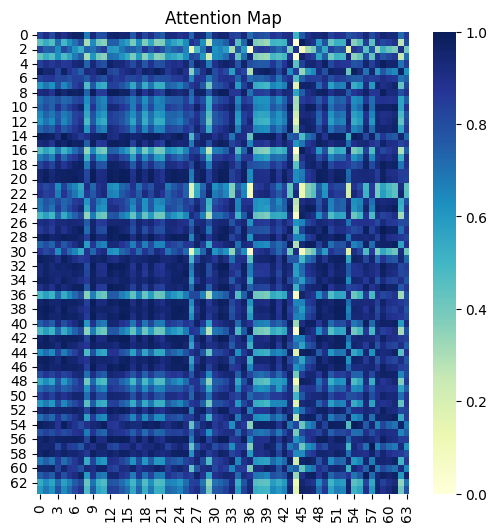

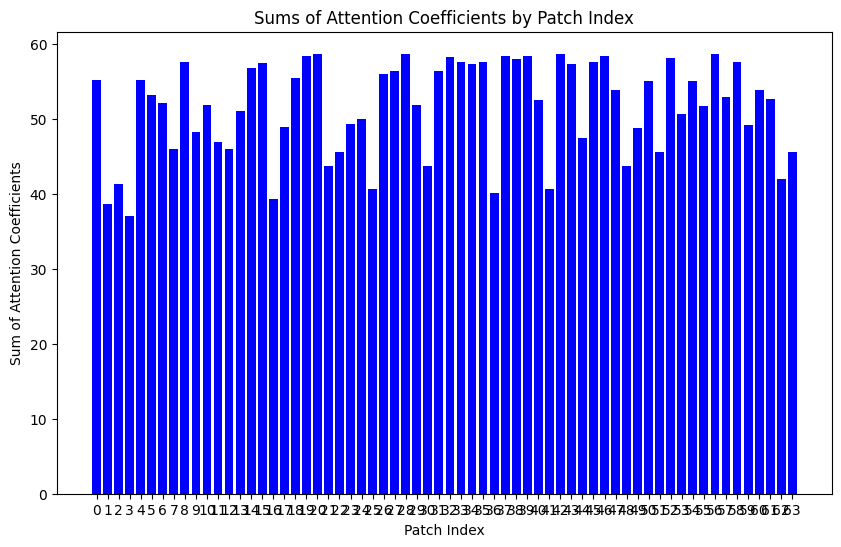

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 52%|█████▏    | 26/50 [13:01:36<12:36:17, 1890.74s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [55.036537 38.48019  41.305542 36.80099  55.50769  53.02385  51.787323
 45.931526 57.72317  47.855946 51.56383  46.555443 45.719807 50.591362
 56.705853 57.53625  39.19587  48.961678 55.63484  58.398148 58.6543
 43.66014  45.27961  49.08823  49.540222 40.503483 56.068092 56.48417
 58.65043  51.492393 43.788437 56.29698  58.277042 57.62219  57.397423
 57.587944 40.761223 58.40045  57.91848  58.39793  52.62356  41.367508
 58.654846 57.31779  47.609276 57.66614  58.451397 53.92507  43.460625
 48.96914  55.313103 46.03027  58.140495 51.15567  55.303955 51.848515
 58.703156 52.896004 57.6218   49.36969  53.9752   52.51728  42.291832
 45.174435]


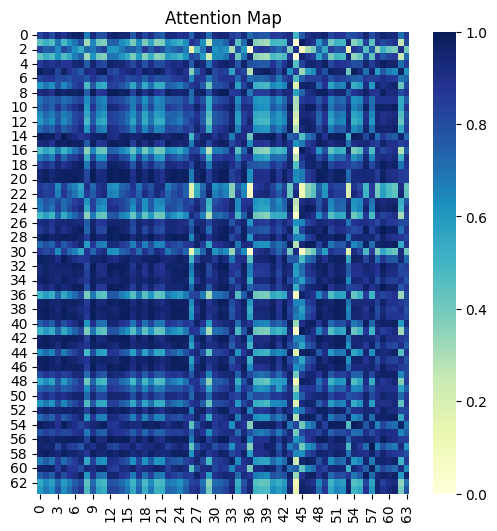

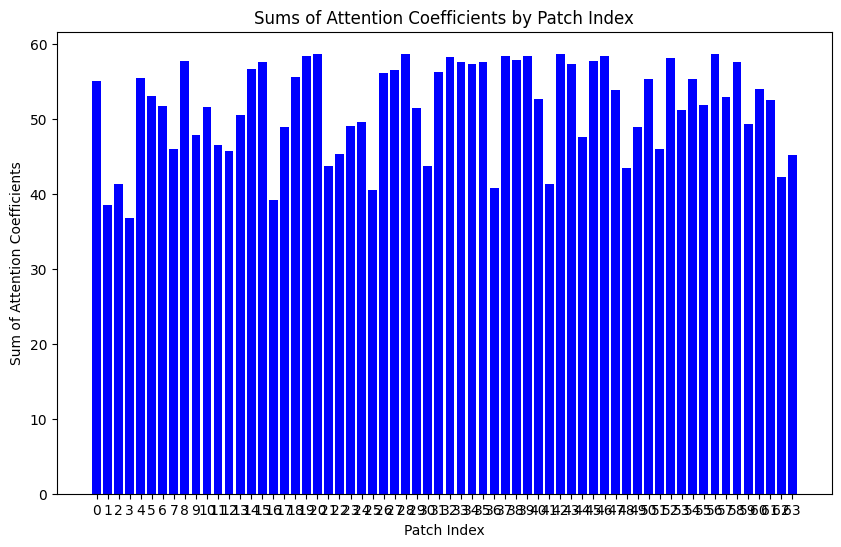

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 54%|█████▍    | 27/50 [13:33:53<12:10:02, 1904.45s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [54.836727 38.296436 41.335083 36.612972 55.839363 52.914455 51.53047
 45.889748 57.895515 47.552307 51.266445 46.14929  45.457294 50.15535
 56.657948 57.621147 39.14252  49.056564 55.8619   58.430443 58.72663
 43.60235  45.06265  48.877197 49.130344 40.388763 56.232407 56.623344
 58.697098 51.200638 43.904938 56.260254 58.357094 57.709618 57.540028
 57.691704 41.479515 58.446857 57.93036  58.412903 52.77646  42.19837
 58.7028   57.332485 47.77348  57.7841   58.52143  54.109764 43.234085
 49.196022 55.595375 46.471657 58.23452  51.63257  55.55788  52.084984
 58.763252 52.873898 57.69487  49.5345   54.150734 52.413994 42.575336
 44.803066]


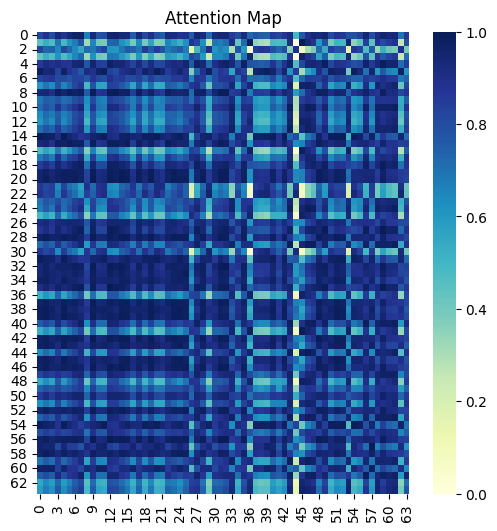

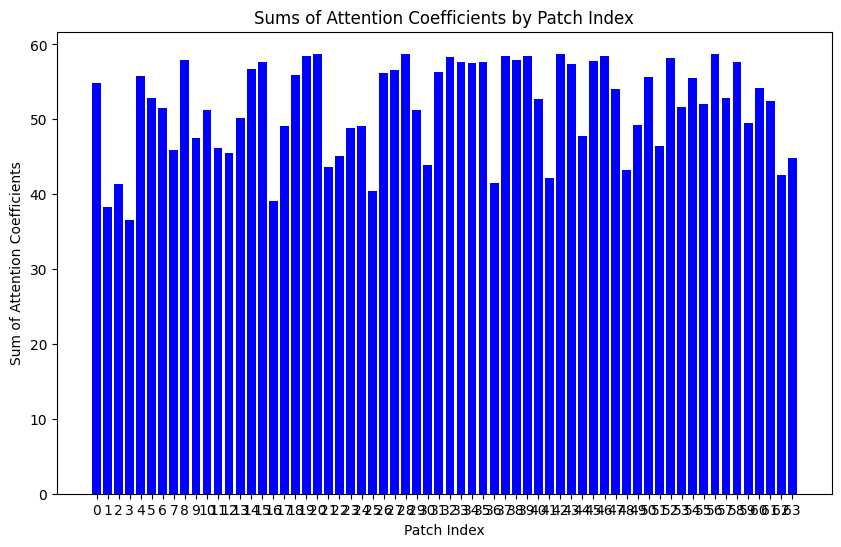

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 56%|█████▌    | 28/50 [14:05:15<11:35:51, 1897.82s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [54.497963 38.023354 41.30205  36.352676 56.05962  52.7012   51.173462
 45.74062  57.936504 47.137707 50.83757  45.619347 45.07415  49.577843
 56.486282 57.581863 38.988815 49.09238  55.966526 58.34584  58.685802
 43.491005 44.760033 48.538    48.594215 40.241554 56.286472 56.668823
 58.62839  50.80529  43.95     56.105103 58.321556 57.67781  57.576942
 57.687843 42.144848 58.385338 57.83744  58.302612 52.826553 42.93759
 58.63262  57.240723 47.83551  57.787544 58.475098 54.182343 42.89684
 49.295914 55.7359   46.781357 58.210857 51.984276 55.69873  52.249165
 58.708656 52.752037 57.654373 49.55611  54.17716  52.14372  42.74205
 44.355568]


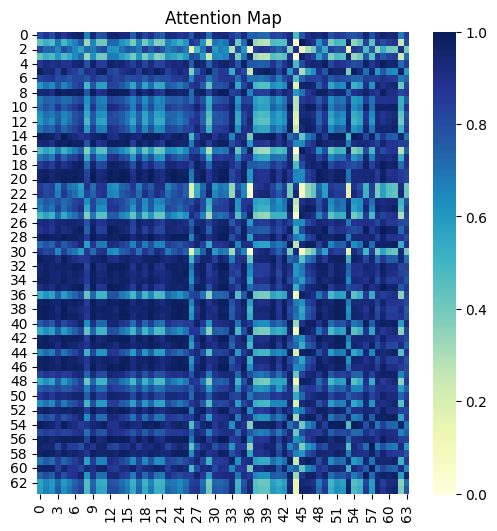

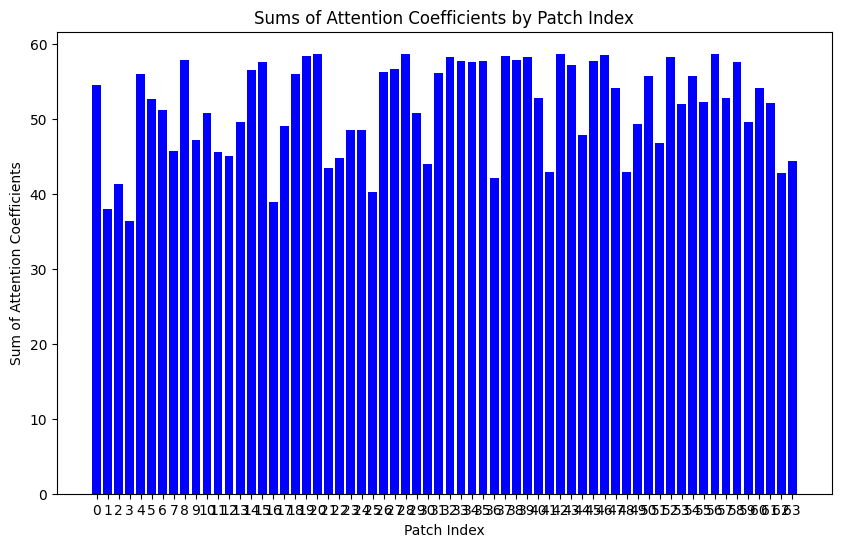

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 58%|█████▊    | 29/50 [14:37:14<11:06:27, 1904.16s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [54.110115 37.71396  41.282356 36.066204 56.25544  52.492134 50.803383
 45.552086 57.94232  46.681442 50.3636   45.046497 44.65989  48.957405
 56.306007 57.514515 38.78714  49.134827 56.03519  58.24287  58.629433
 43.415394 44.468864 48.146477 48.01095  40.087944 56.322296 56.695206
 58.545116 50.380188 44.004234 55.943512 58.26698  57.622566 57.592278
 57.664352 42.769722 58.316364 57.746727 58.171814 52.836308 43.636192
 58.545914 57.143936 47.863033 57.771004 58.408943 54.22575  42.50677
 49.37575  55.827675 47.022785 58.165276 52.290855 55.825554 52.404194
 58.635666 52.648823 57.600197 49.542908 54.168556 51.823685 42.854588
 43.873196]


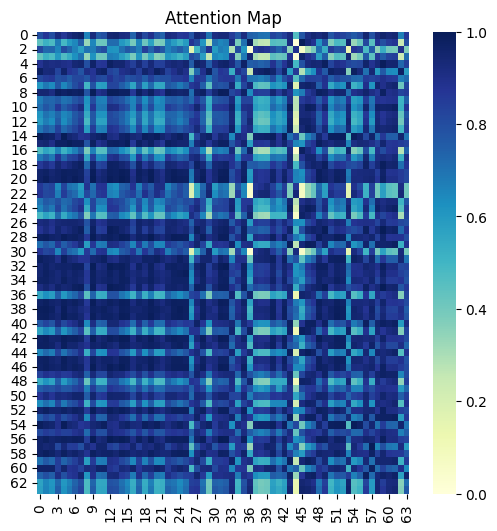

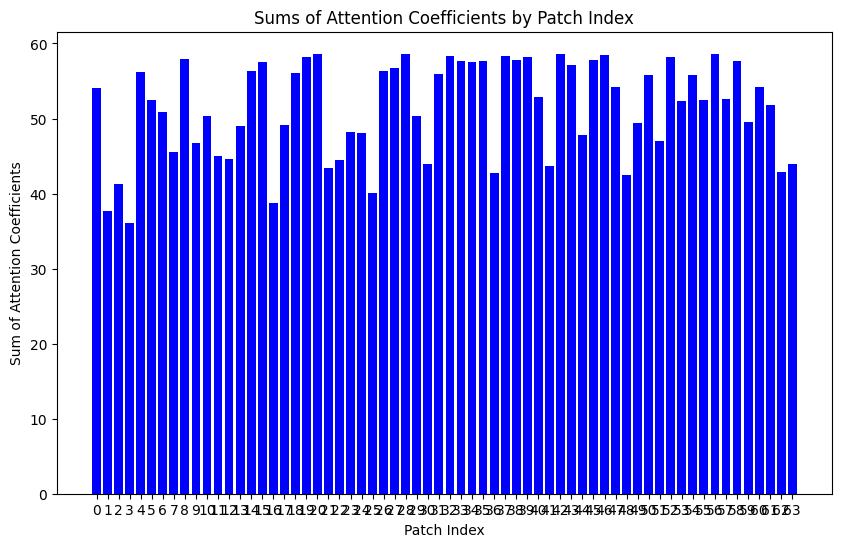

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 60%|██████    | 30/50 [15:08:44<10:33:21, 1900.09s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [53.662888 37.359993 41.291054 35.74336  56.428444 52.307335 50.42299
 45.317223 57.91906  46.17369  49.839836 44.439507 44.230293 48.32293
 56.151676 57.427906 38.527733 49.141476 56.06974  58.128426 58.563255
 43.399307 44.224014 47.70106  47.368427 39.88473  56.342827 56.68887
 58.45352  49.90992  44.082783 55.796646 58.19789  57.54957  57.583954
 57.61752  43.300323 58.246574 57.670586 58.033894 52.791203 44.29191
 58.45276  57.05717  47.858704 57.73787  58.32862  54.238785 42.053062
 49.45739  55.88671  47.204742 58.103653 52.557365 55.95508  52.532707
 58.54773  52.5839   57.54107  49.530373 54.158455 51.497314 42.90216
 43.31157 ]


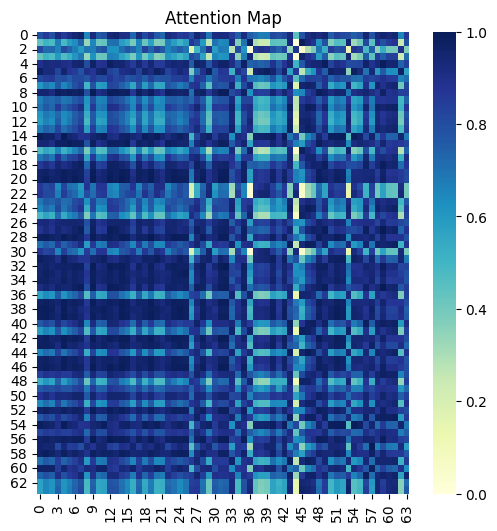

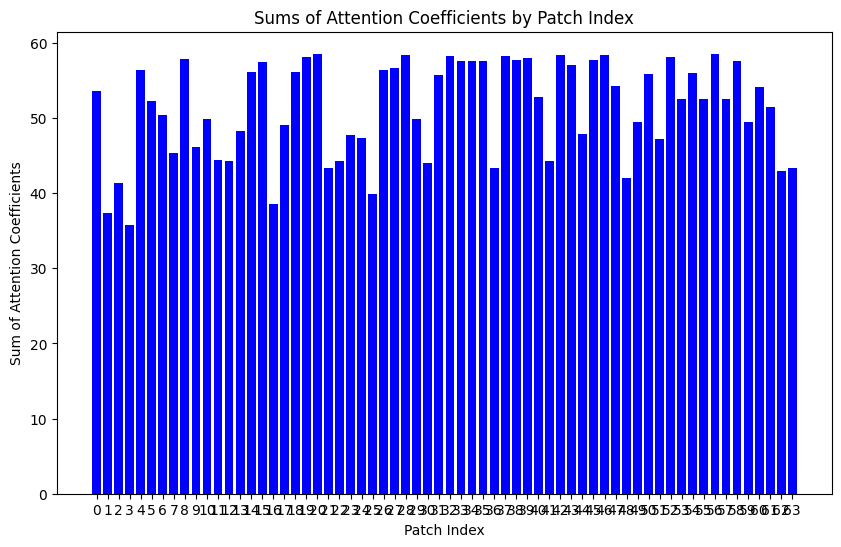

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 62%|██████▏   | 31/50 [15:40:16<10:00:54, 1897.63s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [53.13625  36.950825 41.329056 35.377476 56.571785 52.148186 50.023254
 45.02544  57.863308 45.60034  49.258312 43.798702 43.78643  47.691444
 56.036537 57.32149  38.200123 49.075573 56.066452 57.998062 58.481445
 43.450253 44.03639  47.193558 46.650314 39.59986  56.341057 56.635777
 58.347458 49.3773   44.187244 55.666855 58.10788  57.454033 57.543198
 57.536354 43.701492 58.169533 57.60395  57.889233 52.672035 44.894394
 58.350624 56.98126  47.819496 57.678493 58.22899  54.21206  41.52916
 49.534927 55.91589  47.327446 58.020935 52.778854 56.083755 52.61128
 58.436264 52.5513   57.47245  49.52275  54.154022 51.178123 42.85966
 42.64614 ]


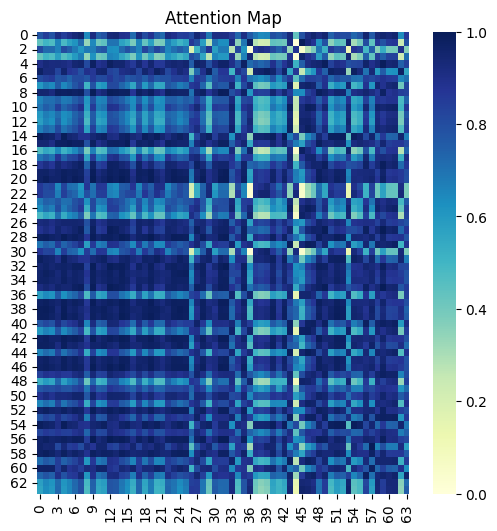

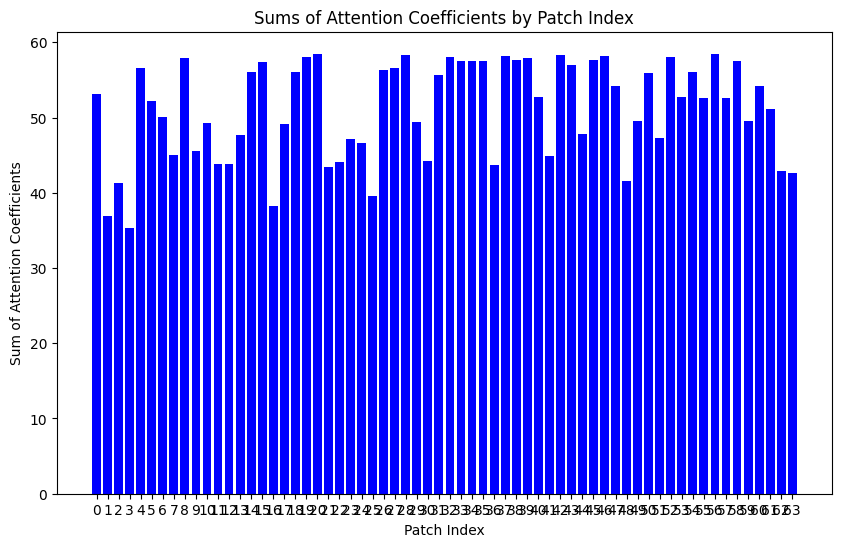

tensor([2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 64%|██████▍   | 32/50 [16:12:55<9:34:46, 1915.89s/it] 

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [52.5245   36.48716  41.393944 34.97425  56.686066 52.01381  49.600616
 44.67865  57.778214 44.960224 48.627678 43.12751  43.327095 47.068153
 55.957844 57.199936 37.807537 48.937927 56.030533 57.85241  58.38384
 43.568596 43.899315 46.624535 45.85796  39.229485 56.317726 56.53917
 58.227123 48.78218  44.31747  55.554436 57.997063 57.337418 57.47035
 57.421192 43.985275 58.084    57.542557 57.74156  52.473457 45.43754
 58.240616 56.916954 47.74822  57.58808  58.110237 54.144794 40.935604
 49.59841  55.918053 47.39157  57.917564 52.955303 56.203457 52.6306
 58.298355 52.545574 57.39391  49.512756 54.14951  50.85819  42.710957
 41.887947]


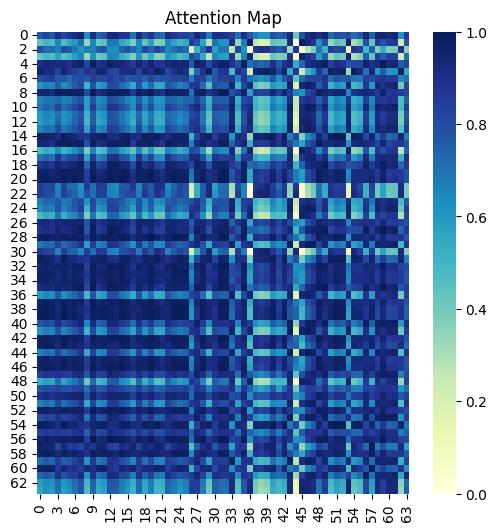

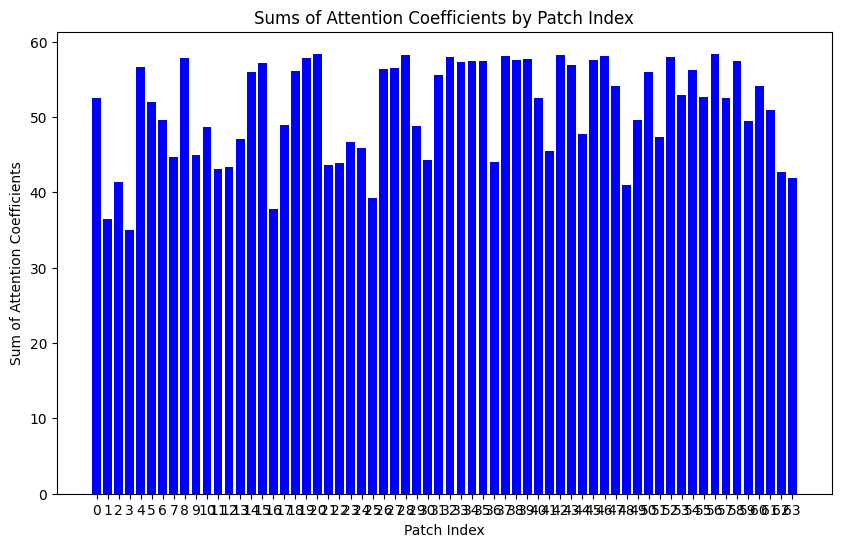

tensor([2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 66%|██████▌   | 33/50 [16:44:59<9:03:31, 1918.31s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [51.84526  35.985313 41.491768 34.55143  56.790035 51.914738 49.166134
 44.297386 57.68446  44.272476 47.9804   42.43683  42.85536  46.45005
 55.911724 57.082977 37.37175  48.769115 55.984787 57.70884  58.287838
 43.757103 43.804855 46.011482 45.014465 38.801018 56.292564 56.427795
 58.111717 48.148193 44.483833 55.472073 57.883698 57.218838 57.38453
 57.294983 44.212463 58.005985 57.49739  57.60982  52.215096 45.926548
 58.139427 56.877716 47.65982  57.479263 57.989674 54.054707 40.288925
 49.6485   55.90883  47.40552  57.81111  53.101616 56.317764 52.610016
 58.149044 52.57748  57.321556 49.49561  54.145348 50.52038  42.464466
 41.075157]


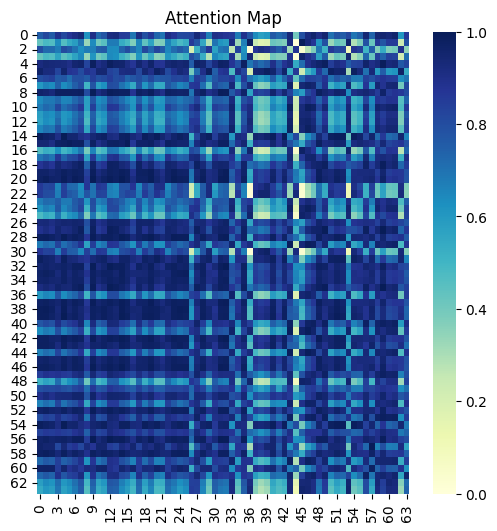

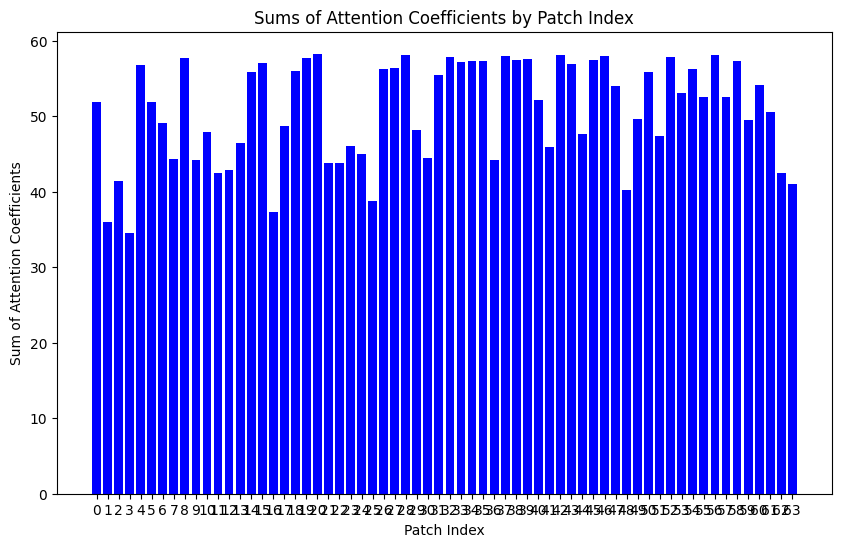

tensor([2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 68%|██████▊   | 34/50 [17:16:16<8:28:15, 1905.94s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [51.137653 35.54062  41.679916 34.206573 56.897766 51.871857 48.75838
 43.949493 57.59469  43.607193 47.380054 41.783607 42.417904 45.85563
 55.88555  56.98217  36.988743 48.637695 55.950066 57.576546 58.200867
 44.053165 43.789757 45.413685 44.18857  38.42121  56.283268 56.331863
 58.01188  47.53437  44.736454 55.43109  57.778275 57.111317 57.29937
 57.17843  44.499615 57.941536 57.47174  57.50325  51.939766 46.40115
 58.05299  56.869164 47.59773  57.357937 57.875763 53.967495 39.673878
 49.70394  55.90052  47.406303 57.710518 53.241356 56.427086 52.59215
 57.994995 52.668015 57.264694 49.47763  54.14778  50.155655 42.192375
 40.3179  ]


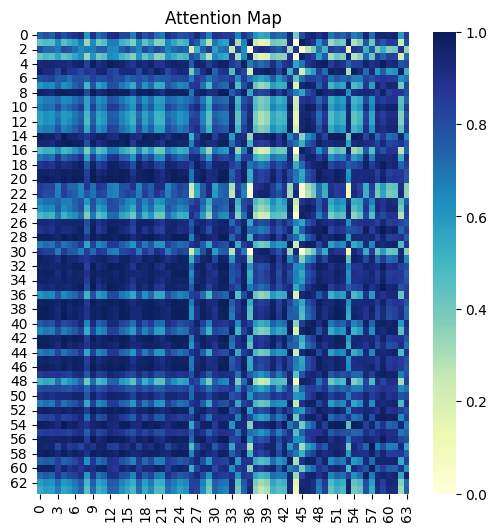

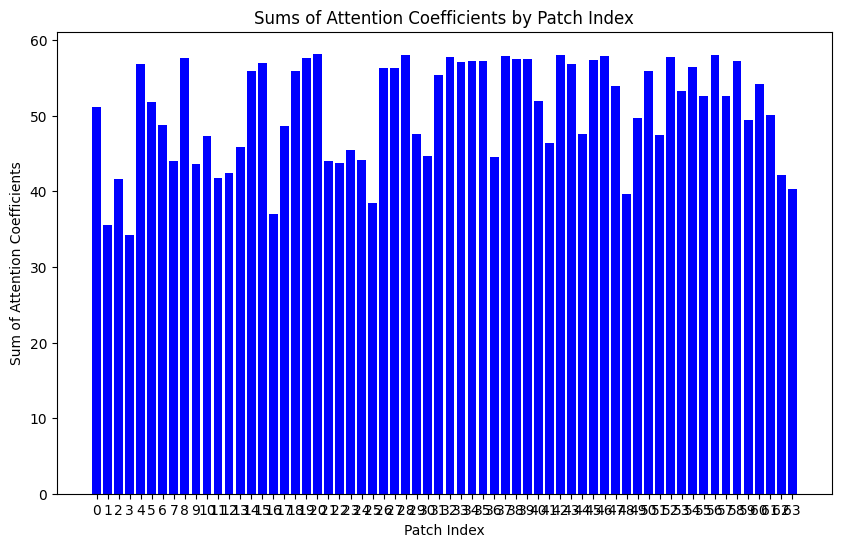

tensor([2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0,
        0, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 70%|███████   | 35/50 [17:47:06<7:52:15, 1889.06s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [50.374424 35.17156  41.930588 33.955357 56.9477   51.826954 48.347275
 43.627445 57.448284 42.96508  46.802017 41.15173  41.989075 45.236412
 55.799683 56.834126 36.672855 48.511185 55.871925 57.393078 58.058445
 44.40325  43.822113 44.820908 43.376537 38.13258  56.232193 56.20685
 57.864914 46.92605  45.03865  55.365273 57.619686 56.95452  57.158775
 57.01864  44.85872  57.823437 57.395493 57.35576  51.630188 46.824715
 57.91536  56.818737 47.534004 57.159214 57.70562  53.837013 39.104156
 49.704346 55.833904 47.360847 57.55281  53.32429  56.46249  52.547554
 57.773567 52.755356 57.159714 49.38791  54.09797  49.70391  41.89811
 39.655823]


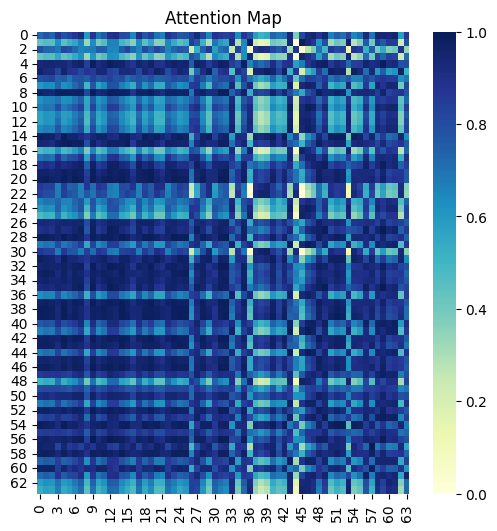

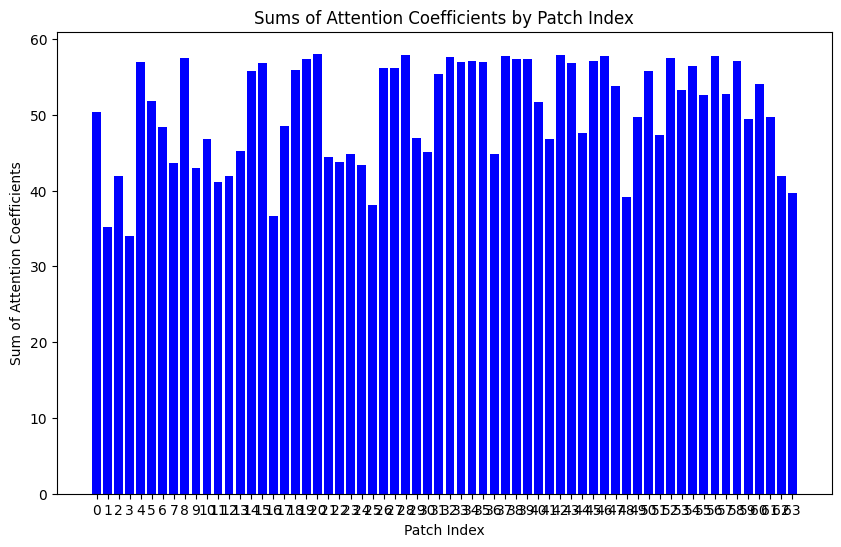

tensor([2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0,
        1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0,
        0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 72%|███████▏  | 36/50 [18:17:47<7:17:27, 1874.80s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [49.585373 34.827057 42.202713 33.73381  56.990913 51.797028 47.947777
 43.322216 57.30226  42.34156  46.22201  40.513096 41.543495 44.58217
 55.697014 56.689323 36.37426  48.38418  55.79825  57.214783 57.920242
 44.761326 43.881226 44.236946 42.571568 37.929825 56.187683 56.10829
 57.727608 46.327583 45.363068 55.306664 57.46693  56.801605 57.02506
 56.873955 45.27496  57.706245 57.318222 57.217617 51.36008  47.20726
 57.784294 56.770805 47.483574 56.936665 57.53774  53.706207 38.552296
 49.652153 55.760674 47.28882  57.395676 53.388702 56.47367  52.516045
 57.546097 52.84482  57.059586 49.22931  54.037846 49.187683 41.57554
 39.06849 ]


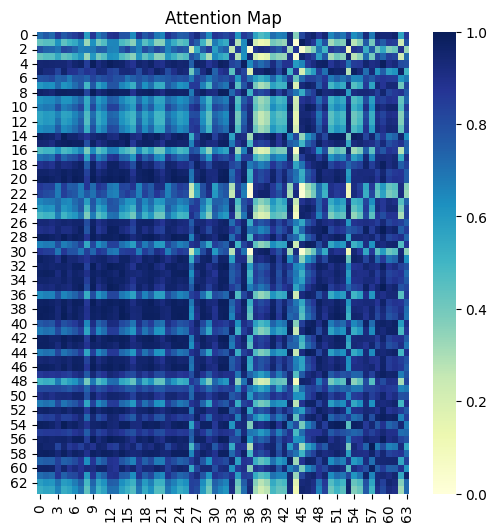

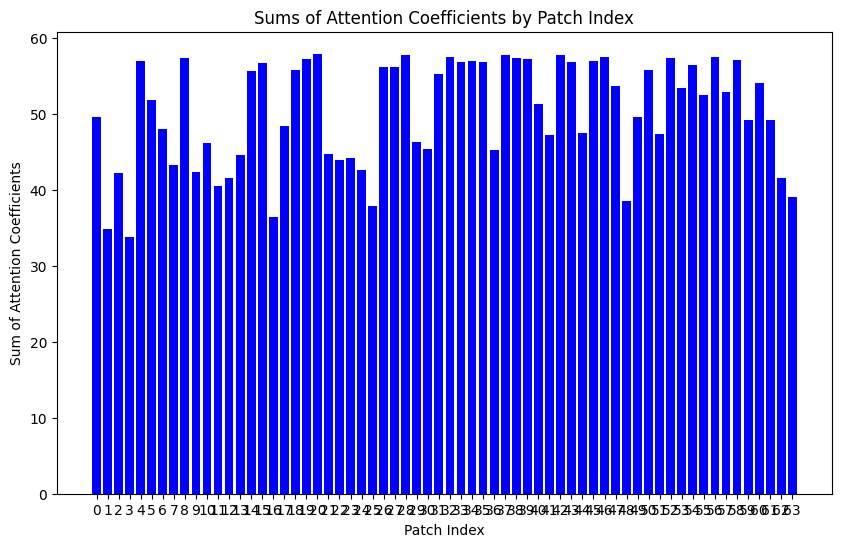

tensor([2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0,
        0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 74%|███████▍  | 37/50 [18:48:22<6:43:38, 1862.94s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [48.78881  34.513626 42.503464 33.548416 57.05069  51.79484  47.59224
 43.044083 57.181175 41.743362 45.615456 39.87632  41.09138  43.90441
 55.60385  56.571213 36.093826 48.2013   55.74948  57.066498 57.811962
 45.11737  43.98394  43.685814 41.785706 37.815163 56.171715 56.05578
 57.62217  45.744957 45.714176 55.26583  57.345844 56.679665 56.928635
 56.769047 45.744843 57.61142  57.26268  57.110752 51.194477 47.590786
 57.685577 56.74099  47.476784 56.714012 57.39865  53.600105 38.025803
 49.568703 55.712414 47.237648 57.26575  53.464287 56.49212  52.5185
 57.34053  52.92849  56.98892  49.030437 53.997536 48.642883 41.237343
 38.537254]


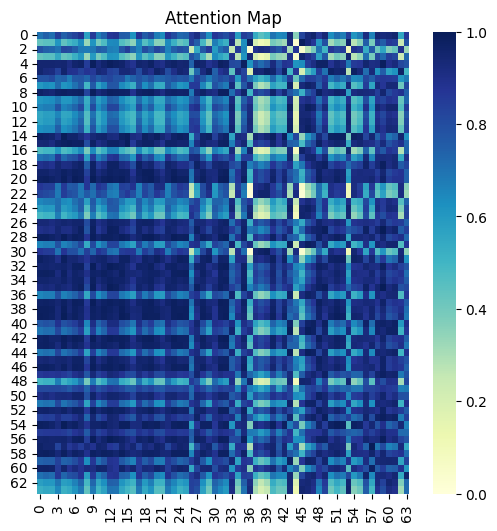

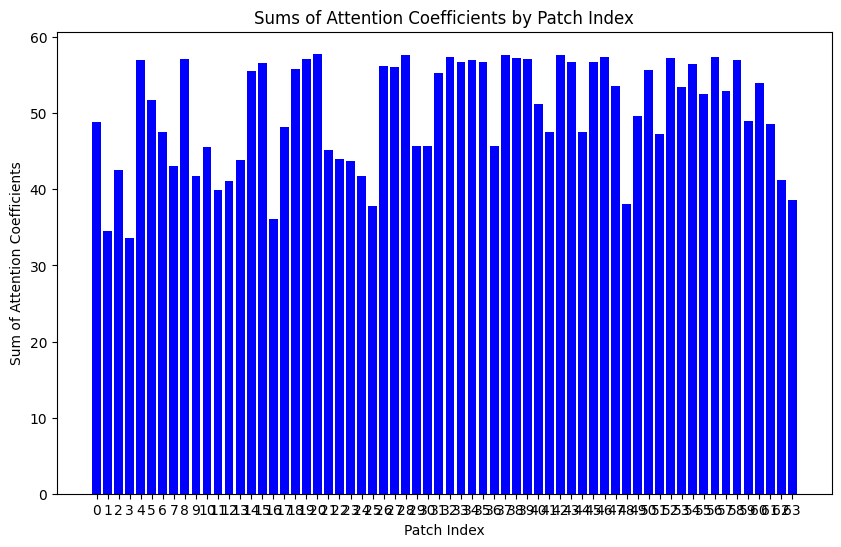

tensor([2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0,
        0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1,
        0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 76%|███████▌  | 38/50 [19:19:05<6:11:23, 1856.98s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [47.985085 34.222023 42.82065  33.392048 57.12087  51.82093  47.311275
 42.777756 57.079987 41.14761  44.967    39.24122  40.62861  43.204987
 55.526314 56.480217 35.81765  47.948387 55.71929  56.943428 57.730003
 45.46574  44.121803 43.16978  41.010498 37.74077  56.176353 56.0362
 57.54199  45.160355 46.069183 55.231583 57.252644 56.586426 56.86201
 56.69623  46.239723 57.53208  57.222652 57.029552 51.126656 47.994274
 57.615242 56.72014  47.497574 56.486984 57.286095 53.51657  37.513077
 49.4561   55.69285  47.22974  57.15927  53.55357  56.519924 52.54675
 57.15143  53.001266 56.9451   48.81236  53.98369  48.127113 40.86808
 38.00889 ]


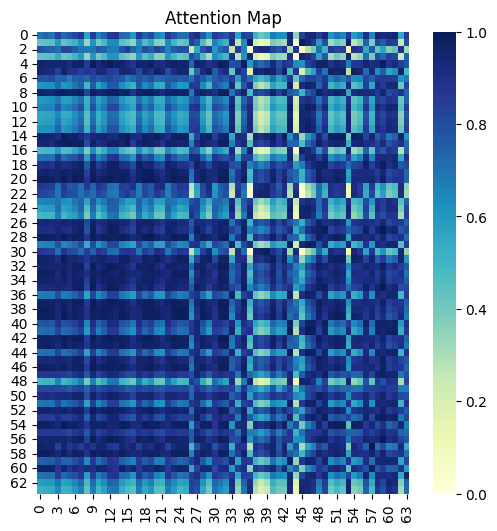

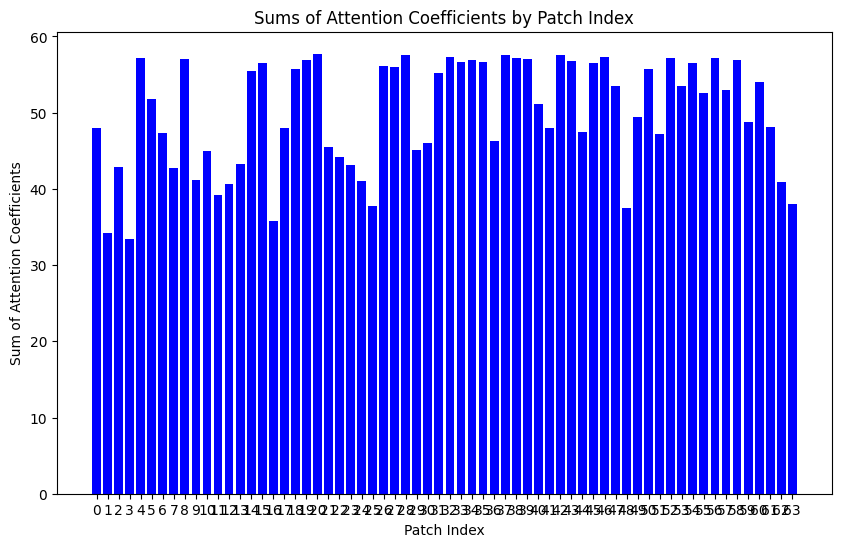

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1,
        0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 78%|███████▊  | 39/50 [19:50:13<5:41:01, 1860.12s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [47.149918 33.92177  43.132294 33.22926  57.179806 51.894394 47.09046
 42.491386 56.982315 40.53073  44.269142 38.597412 40.145943 42.50833
 55.47447  56.411793 35.51732  47.670567 55.694344 56.826225 57.656845
 45.806953 44.276817 42.674553 40.21415  37.61977  56.17886  56.017685
 57.467476 44.5399   46.39724  55.20437  57.16822  56.505432 56.802223
 56.6243   46.69334  57.45259  57.181885 56.959675 51.10364  48.401352
 57.55542  56.68898  47.491245 56.235443 57.18154  53.434284 36.980133
 49.297462 55.686157 47.244957 57.055756 53.63784  56.54287  52.57498
 56.954334 53.05945  56.910606 48.588596 53.987724 47.717636 40.434357
 37.426407]


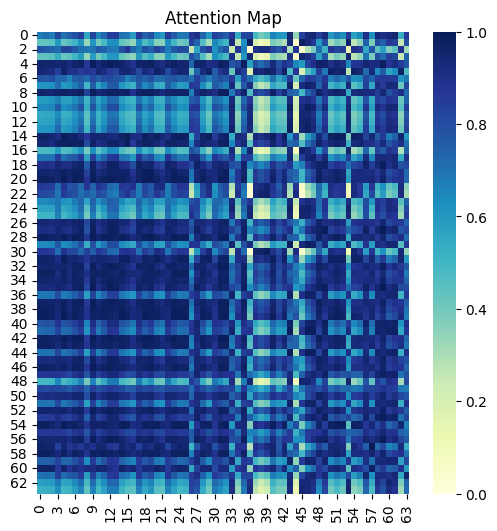

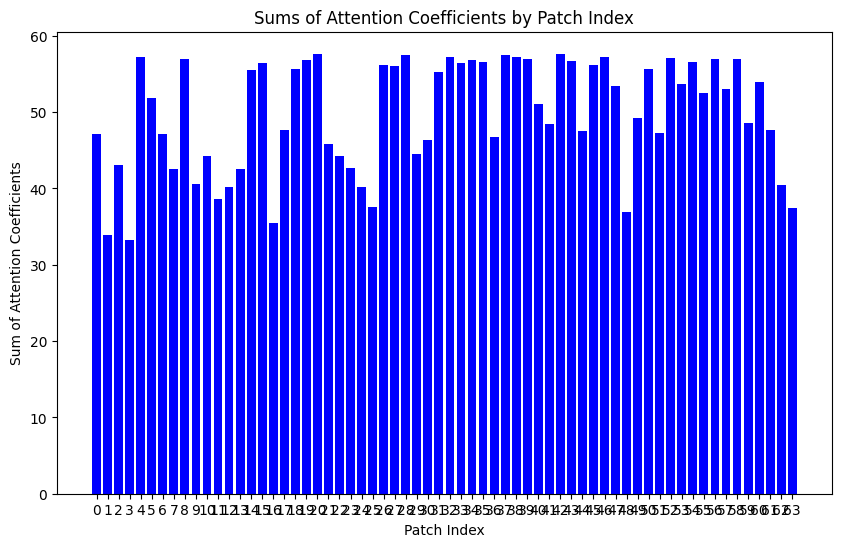

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1,
        2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 80%|████████  | 40/50 [20:21:00<5:09:21, 1856.17s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [46.27661  33.597794 43.4284   33.039436 57.219227 52.01577  46.907024
 42.173576 56.883675 39.88685  43.529793 37.942368 39.643394 41.843792
 55.448532 56.364014 35.18272  47.429222 55.66908  56.707275 57.58651
 46.146107 44.440605 42.19581  39.38447  37.404755 56.16998  55.98485
 57.39158  43.870316 46.689426 55.191124 57.084953 56.429512 56.740456
 56.537083 47.068687 57.370758 57.13603  56.896515 51.09369  48.79762
 57.499245 56.636982 47.427032 55.950058 57.076538 53.344482 36.410126
 49.08432  55.684753 47.267654 56.94563  53.707924 56.553818 52.591614
 56.73803  53.102047 56.878643 48.36811  54.002815 47.4308   39.926033
 36.777687]


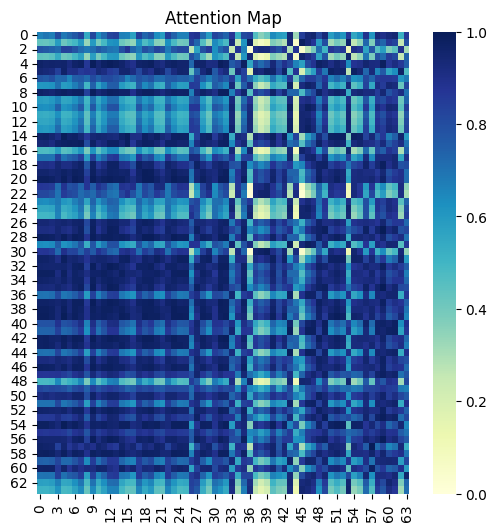

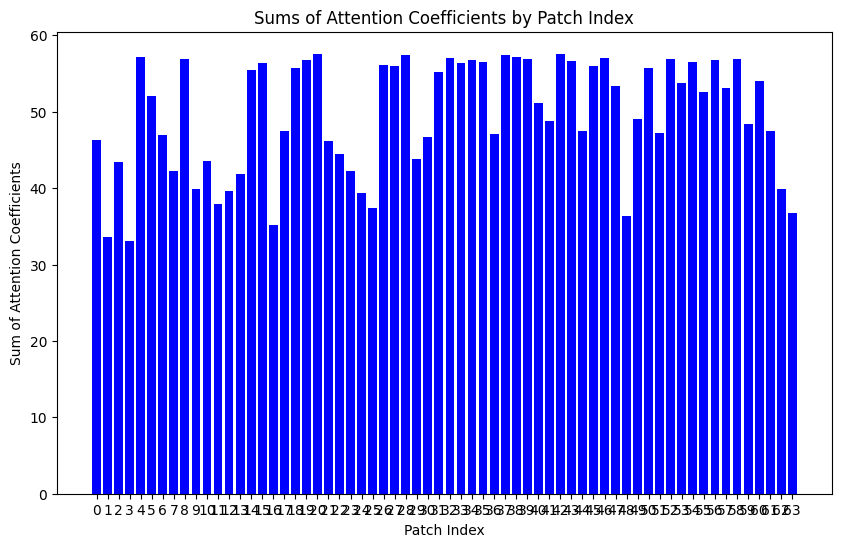

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1,
        2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 82%|████████▏ | 41/50 [20:51:24<4:36:59, 1846.62s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [45.37575  33.25956  43.709244 32.827385 57.237675 52.175865 46.754066
 41.83145  56.785194 39.231926 42.77439  37.28611  39.1278   41.2125
 55.43724  56.332264 34.827427 47.255753 55.64257  56.584087 57.51735
 46.48197  44.609695 41.736244 38.530823 37.1191   56.15055  55.93943
 57.313442 43.158535 46.951496 55.192375 57.001198 56.35666  56.67323
 56.433365 47.37703  57.287598 57.08515  56.83747  51.08912  49.176247
 57.444035 56.569553 47.302002 55.62819  56.967144 53.247837 35.811157
 48.811646 55.68452  47.293865 56.82434  53.760624 56.54812  52.60028
 56.502037 53.13461  56.846558 48.130398 54.024246 47.24459  39.359295
 36.082   ]


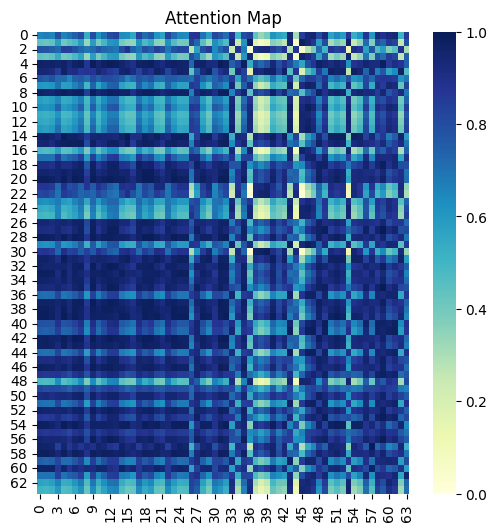

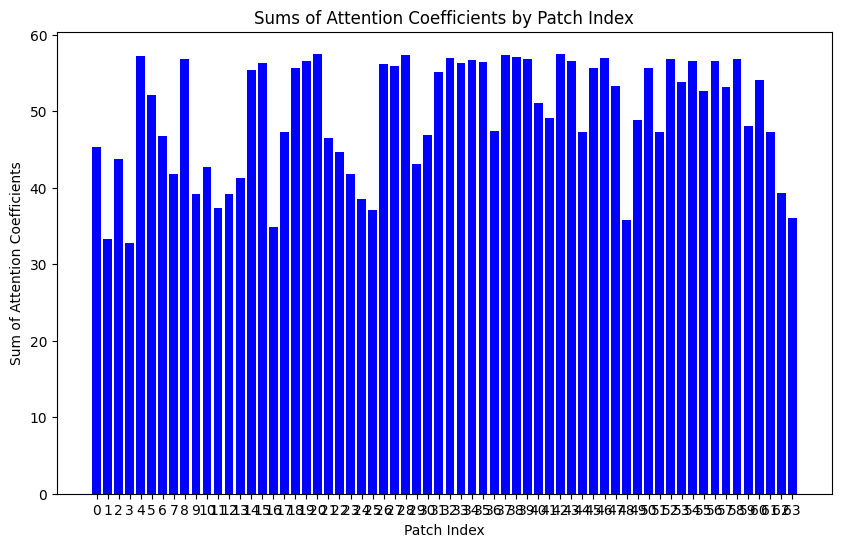

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1,
        0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 84%|████████▍ | 42/50 [21:21:34<4:04:44, 1835.59s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [44.470924 32.930634 43.98298  32.612762 57.23979  52.359753 46.634853
 41.484703 56.692    38.59188  42.032585 36.641922 38.601196 40.579002
 55.423786 56.310356 34.479794 47.12623  55.616577 56.458805 57.4515
 46.79942  44.78489  41.30233  37.67614  36.83489  56.12966  55.89711
 57.237038 42.429276 47.199154 55.202    56.92081  56.289707 56.603237
 56.32602  47.6623   57.20628  57.033375 56.78225  51.09771  49.53297
 57.391415 56.499172 47.13801  55.27389  56.853992 53.152275 35.2116
 48.48226  55.684853 47.32679  56.692444 53.796993 56.52532  52.61471
 56.261776 53.1659   56.815865 47.82818  54.050255 47.114326 38.771896
 35.388813]


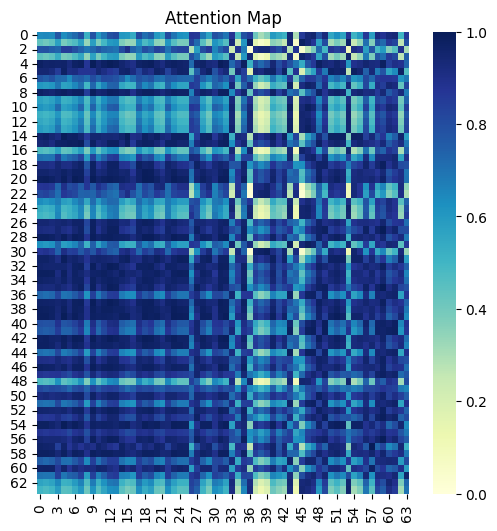

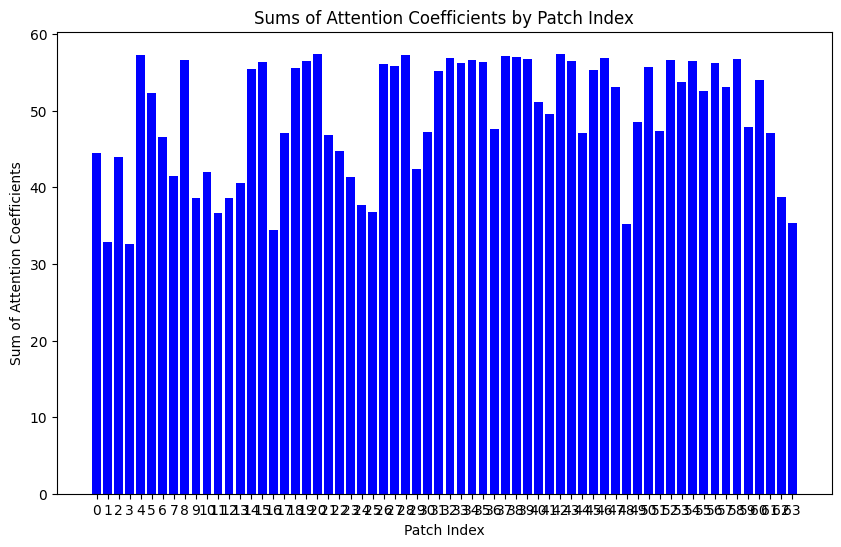

tensor([2, 0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 86%|████████▌ | 43/50 [21:52:37<3:35:06, 1843.81s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [43.568363 32.615593 44.240456 32.397095 57.21092  52.52636  46.523666
 41.135292 56.586575 37.966328 41.303368 35.99948  38.043716 39.886585
 55.367588 56.270134 34.15148  46.95884  55.566402 56.313385 57.370358
 47.058395 44.950264 40.882538 36.8257   36.605267 56.094795 55.85254
 57.14554  41.700493 47.432556 55.19513  56.826805 56.209908 56.51524
 56.213615 47.94429  57.10717  56.96411  56.710415 51.106453 49.83564
 57.322365 56.4109   46.942875 54.872524 56.717644 53.04551  34.62329
 48.088203 55.66498  47.347336 56.52961  53.7974   56.466057 52.62573
 56.027885 53.177902 56.768093 47.409447 54.05838  46.945076 38.196487
 34.753784]


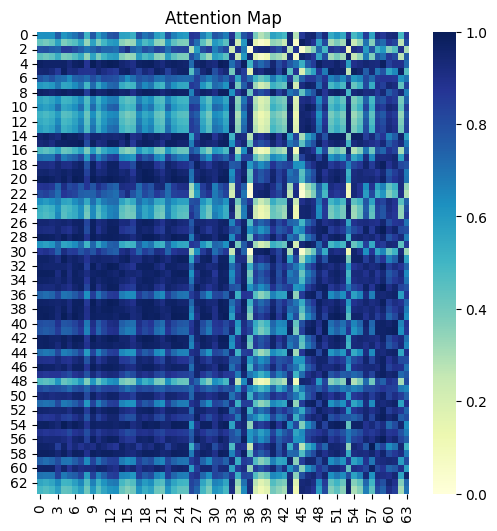

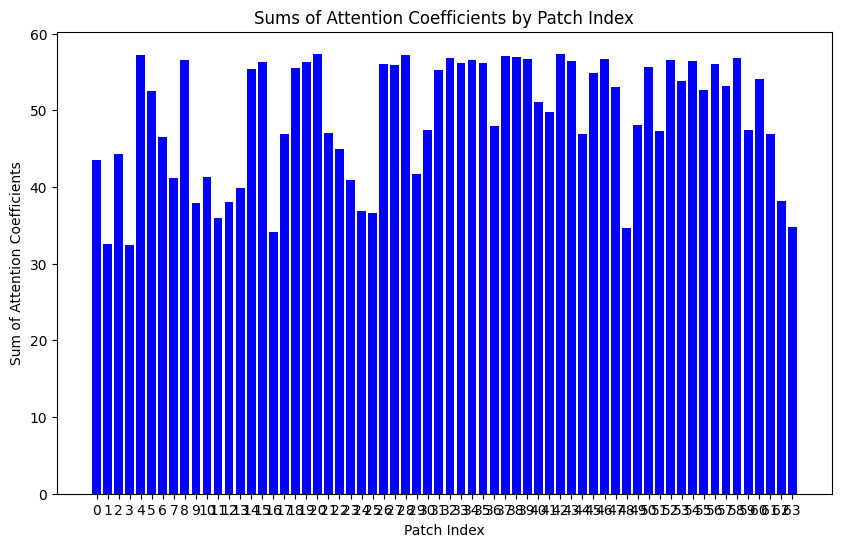

tensor([2, 0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 88%|████████▊ | 44/50 [22:24:10<3:05:50, 1858.48s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [42.680233 32.311264 44.478333 32.173233 57.15107  52.661797 46.38868
 40.78514  56.467613 37.35604  40.59045  35.351    37.453663 39.132336
 55.25768  56.20433  33.846962 46.676502 55.48758  56.1448   57.27031
 47.243248 45.101772 40.470562 35.982265 36.44596  56.04483  55.804424
 57.037254 40.994293 47.65625  55.174713 56.71614  56.113483 56.40827
 56.101494 48.223923 56.985443 56.875416 56.62069  51.105396 50.058144
 57.233562 56.299614 46.72885  54.423435 56.553448 52.92334  34.052597
 47.632915 55.61931  47.33925  56.3304   53.755547 56.36825  52.630623
 55.818455 53.1652   56.699112 46.873756 54.03989  46.652397 37.663525
 34.219643]


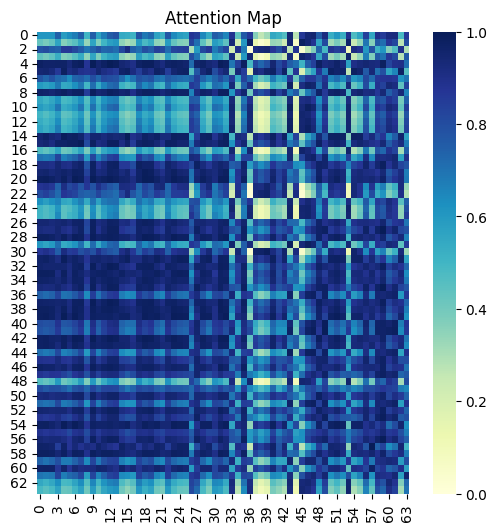

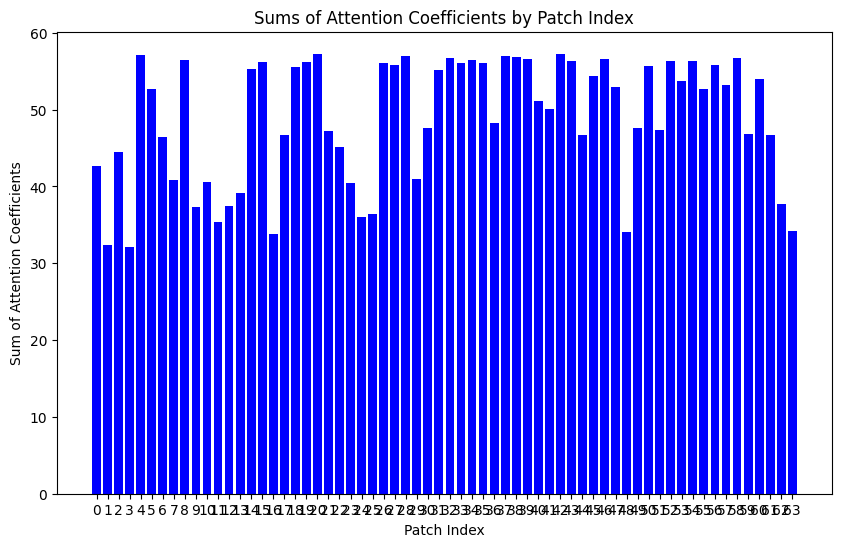

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 90%|█████████ | 45/50 [22:54:36<2:34:03, 1848.74s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [41.8335   32.023613 44.714348 31.94609  57.086914 52.793514 46.226486
 40.449036 56.362587 36.77305  39.921307 34.710808 36.85174  38.35039
 55.125076 56.1382   33.576683 46.299515 55.407204 55.979176 57.17737
 47.39045  45.260056 40.075806 35.159676 36.355686 56.00462  55.774353
 56.939243 40.337048 47.893456 55.173447 56.613525 56.022293 56.308285
 56.01326  48.511337 56.8657   56.793957 56.54103  51.104595 50.21226
 57.151035 56.193024 46.51529  53.9523   56.385513 52.80571  33.50981
 47.140724 55.573257 47.31814  56.118126 53.69449  56.260567 52.6502
 55.657425 53.155174 56.634266 46.25885  54.01943  46.249393 37.19552
 33.797745]


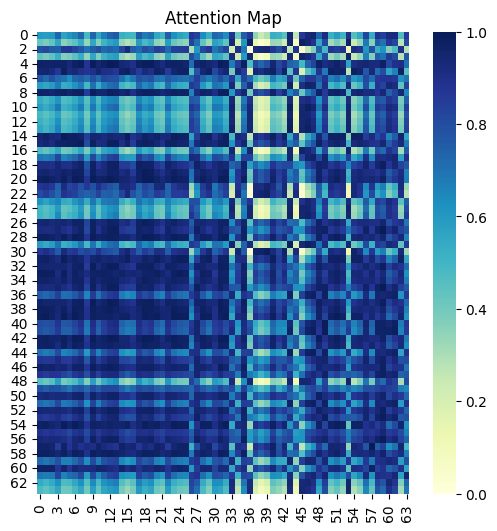

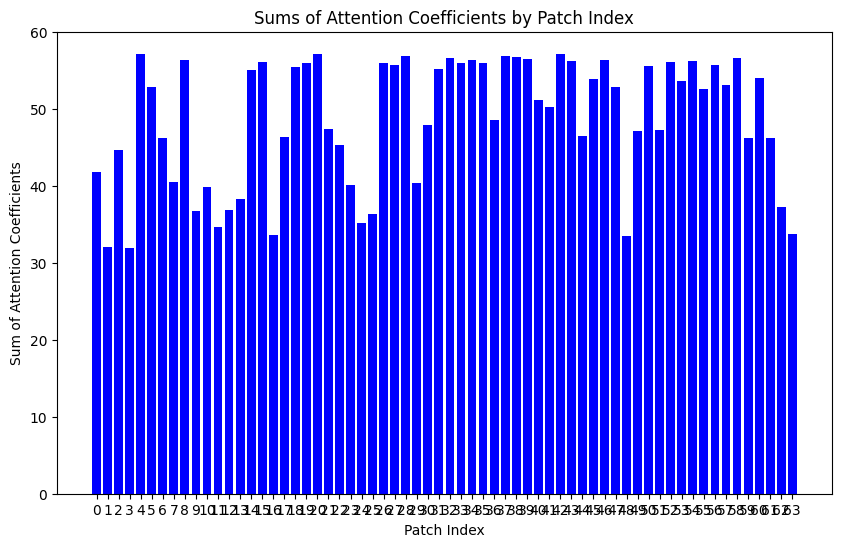

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 92%|█████████▏| 46/50 [23:25:15<2:03:03, 1845.86s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [41.021572 31.74027  44.95     31.706938 57.018642 52.927563 46.023872
 40.112328 56.27069  36.198883 39.288353 34.076187 36.237152 37.54957
 54.97908  56.071045 33.32737  45.827    55.327484 55.816906 57.091236
 47.518806 45.429    39.686764 34.34314  36.30048  55.972496 55.756786
 56.851543 39.723    48.14507  55.192047 56.51728  55.93358  56.215294
 55.943916 48.79223  56.747185 56.719536 56.471794 51.089405 50.296124
 57.07468  56.094494 46.305    53.460594 56.21132  52.68759  32.974213
 46.611847 55.529068 47.28676  55.891792 53.615303 56.146736 52.679253
 55.534046 53.146767 56.572975 45.577892 53.999374 45.751526 36.77083
 33.45644 ]


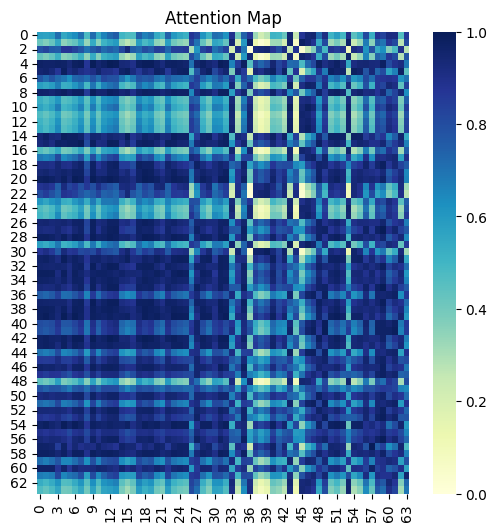

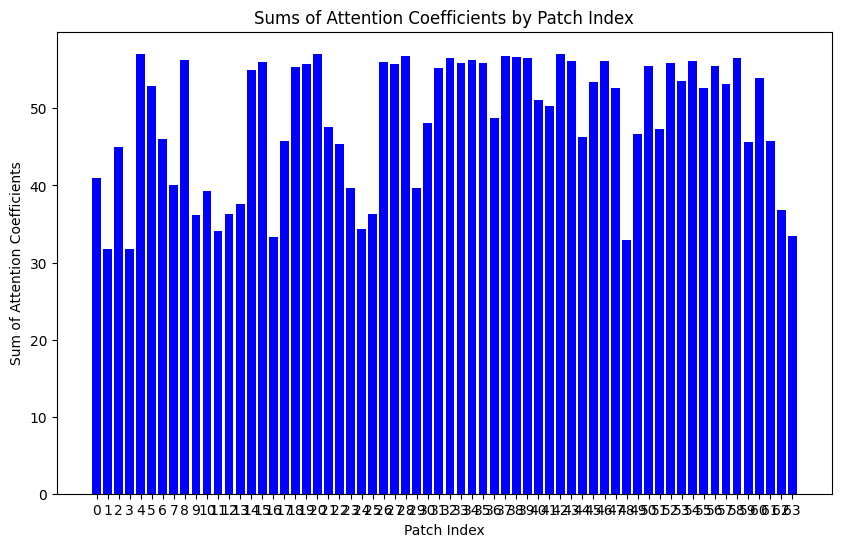

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 94%|█████████▍| 47/50 [23:55:36<1:31:54, 1838.29s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [40.23047  31.448748 45.189255 31.448963 56.94636  53.07024  45.775608
 39.75766  56.18905  35.607964 38.66655  33.440582 35.606384 36.732616
 54.82941  56.001587 33.08182  45.244923 55.250317 55.657722 57.011284
 47.641605 45.61387  39.293266 33.512596 36.23787  55.946373 55.746166
 56.77295  39.135933 48.410843 55.226128 56.42565  55.847984 56.129295
 55.888325 49.053947 56.629696 56.6511   56.41192  51.048935 50.313118
 57.004105 56.006752 46.108517 52.95238  56.0278   52.564735 32.424904
 46.04515  55.489487 47.252373 55.652157 53.520428 56.030174 52.711884
 55.436382 53.132324 56.514412 44.84021  53.981846 45.17211  36.356705
 33.15709 ]


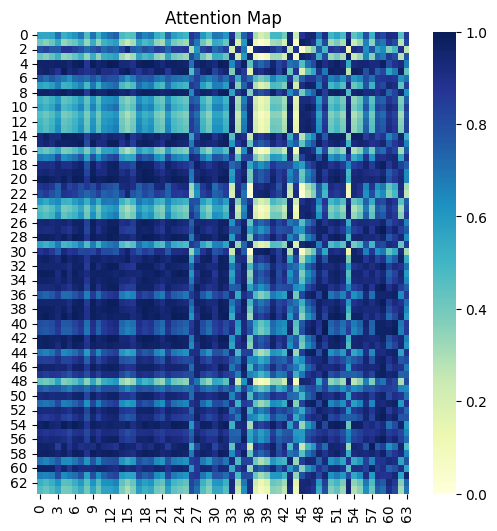

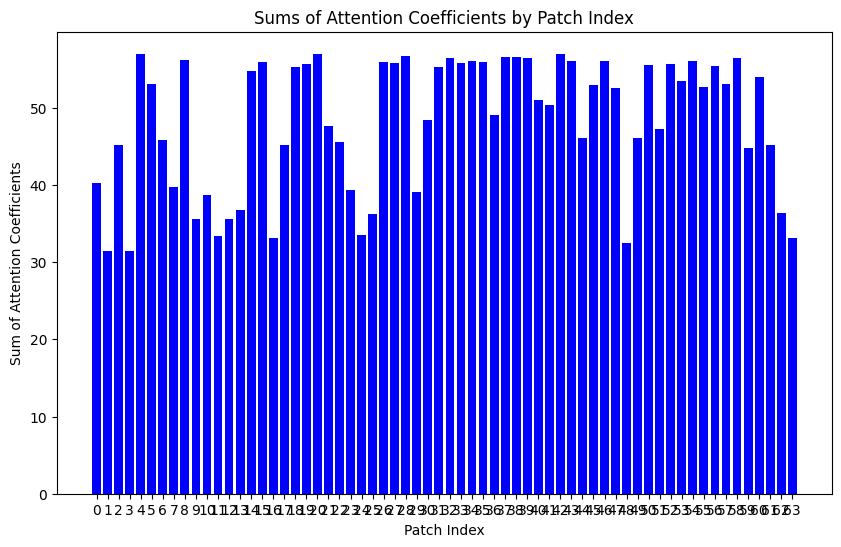

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 96%|█████████▌| 48/50 [24:25:43<1:00:58, 1829.03s/it]

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [39.449883 31.142517 45.435608 31.170097 56.870842 53.226257 45.48464
 39.375248 56.114376 34.977463 38.018826 32.794777 34.956955 35.89995
 54.68431  55.92971  32.826477 44.538696 55.177193 55.5011   56.937195
 47.762768 45.817738 38.89186  32.65529  36.130096 55.924854 55.739265
 56.70185  38.55801  48.68693  55.26973  56.338184 55.77009  56.050446
 55.843277 49.28953  56.514324 56.587738 56.359947 50.981792 50.271442
 56.93925  55.932034 45.941383 52.43654  55.83262  52.436153 31.854612
 45.440388 55.457367 47.22407  55.403755 53.413544 55.913548 52.743843
 55.356506 53.102364 56.45831  44.053955 53.967964 44.52112  35.928284
 32.869255]


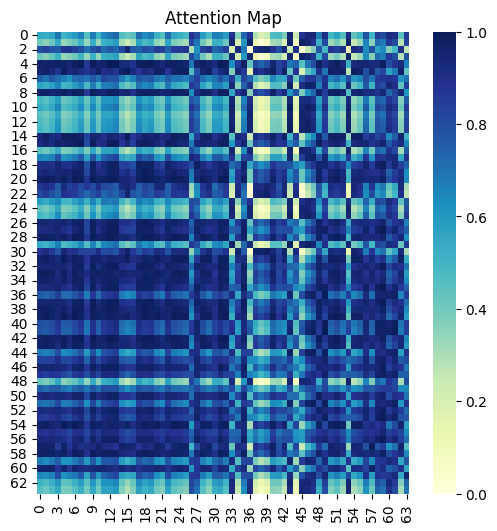

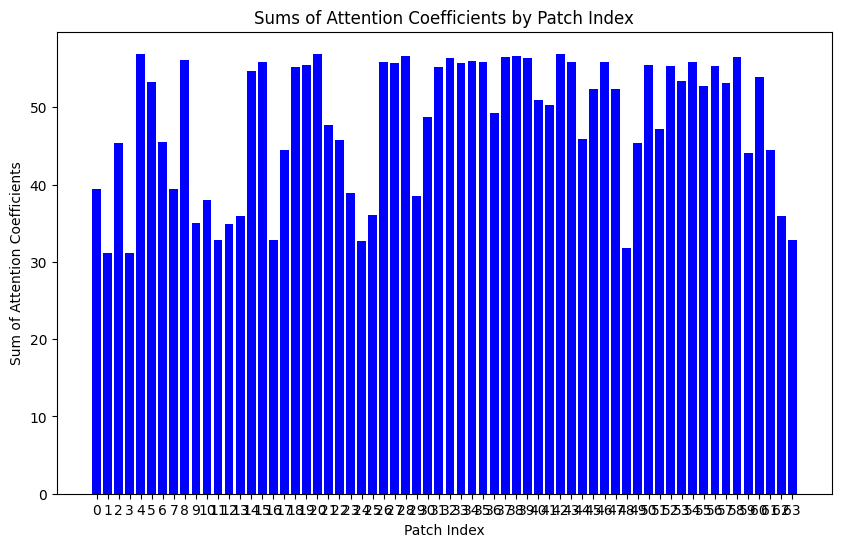

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 98%|█████████▊| 49/50 [24:56:37<30:36, 1836.44s/it]  

Model parameters saved (epoch).
torch.Size([240, 64, 16])
Row sums: [38.711243 30.866552 45.712593 30.915989 56.80207  53.409157 45.185307
 38.998337 56.05384  34.336838 37.35154  32.173195 34.329052 35.089954
 54.55933  55.86726  32.596725 43.733574 55.119164 55.356613 56.87738
 47.898174 46.06127  38.52034  31.812275 35.996185 55.91709  55.74559
 56.6456   38.012154 48.983932 55.328518 56.264954 55.716957 55.988327
 55.817104 49.516273 56.411247 56.538017 56.32341  50.912315 50.19971
 56.888832 55.8816   45.838562 51.93821  55.63406  52.318836 31.310324
 44.823143 55.444683 47.230354 55.165134 53.31092  55.807663 52.7862
 55.302536 53.06609  56.414047 43.253838 53.969345 43.83297  35.516457
 32.620796]


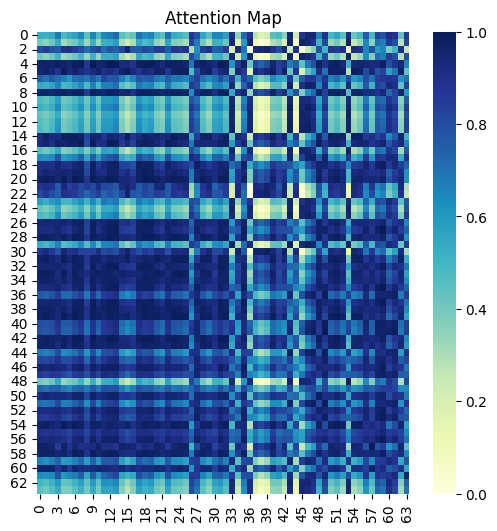

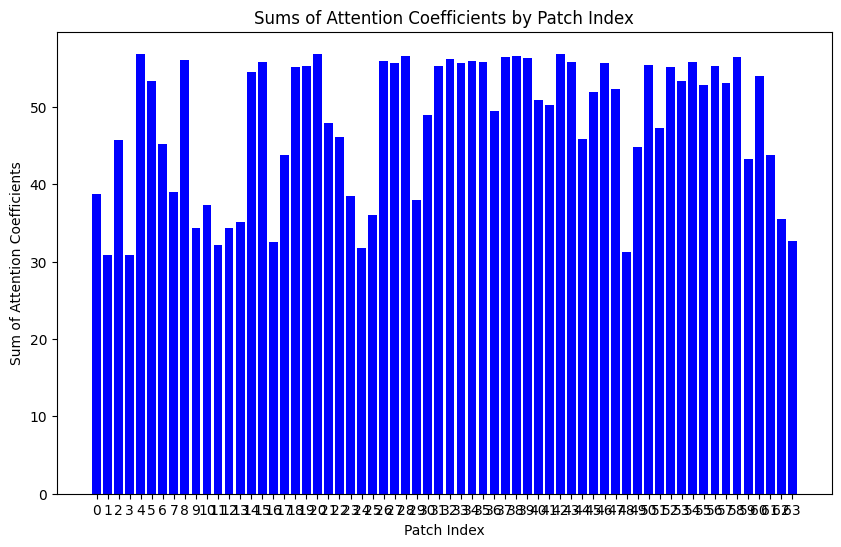

tensor([2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

100%|██████████| 50/50 [25:27:15<00:00, 1832.71s/it]

Model parameters saved (epoch).
Model parameters saved.


In [15]:
for iepoch in tqdm(range(50)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    # Save the model parameters
    torch.save(model.state_dict(), model_save_path)
    print("Model parameters saved (epoch).")

# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")

torch.Size([60, 64, 16])
Row sums: [37.950737 31.32893  45.788166 31.672176 56.791344 53.7065   43.34189
 36.668945 55.781506 34.147972 36.293198 31.856405 32.540237 34.349167
 55.096916 55.930458 32.923897 42.79531  55.44911  55.067154 56.954155
 48.156845 47.011505 38.275352 31.116982 34.131817 55.62468  55.56772
 56.58069  39.127018 49.11026  55.608917 56.325226 55.905907 56.470566
 55.875813 48.91252  56.377953 56.539993 56.37613  50.99997  50.125057
 56.935963 56.07373  46.216206 51.752453 55.162888 52.83259  31.575188
 46.641167 55.737713 46.42096  55.19648  53.774094 55.89505  53.570847
 55.46361  53.031864 56.568207 44.154533 53.833282 43.21084  35.78694
 32.676502]


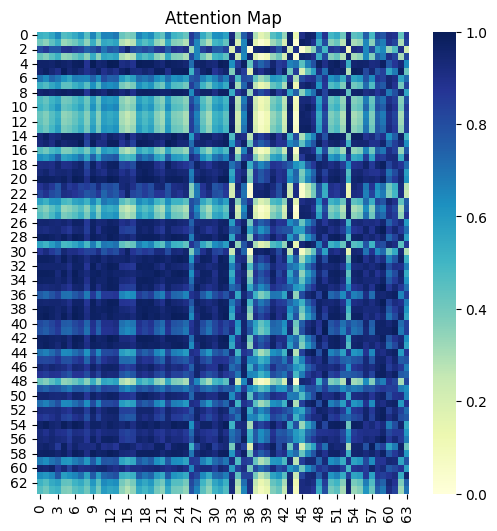

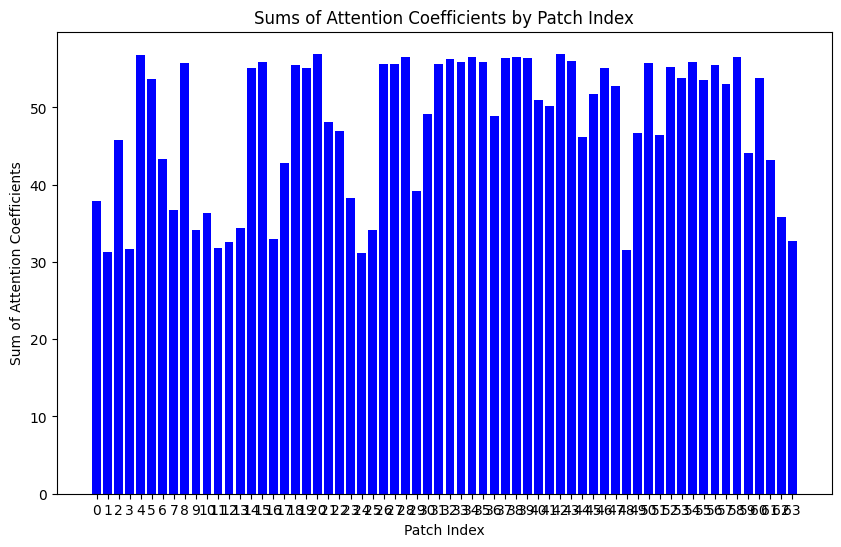

tensor([2, 0, 1, 2, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2,
        2, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 2, 2, 1, 2,
        0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 1, 1])
tensor([0., 0., 2., 2., 2., 0., 1., 0., 2., 0., 0., 2., 2., 1., 1., 2., 0., 2.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 2., 0., 2., 1.,
        2., 0., 0., 1., 2., 2., 1., 2., 0., 0., 1., 2., 1., 2., 1., 1., 2., 0.,
        1., 2., 2., 2., 1., 1.], dtype=torch.float64)

Accuracy: 0.5833333134651184

AUROC: 0.6904166666666667

Precision (macro): 0.603476535541753

Recall (macro): 0.5833333333333334

F1 Score (macro): 0.5893888783849079

AUPRC (macro): 0.6060089651981402



In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)

loss = criterion(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_1.pth"

In [28]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [29]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

In [30]:
# # Training the model
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor = torch.tensor(X_train)
#     predictions = model(X_tensor.float()).squeeze(1)
    
#     label = torch.tensor(y_train)
#     for i in range(len(label)):
#         label[i] = 0 if label[i] == 1 else 1
    
#     loss = criterion(predictions, label.float())
#     acc = binary_accuracy(predictions, label)
#     print(f'Accuracy: {acc}')
#     print(f'Loss: {loss}')
    
#     loss.backward()
#     optimizer.step()
#     print(f"Complete {iepoch} th")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

Row sums: [54.11699  56.878517 43.35569  56.913185 55.968674 35.168243 54.307762
 48.510445 55.78875  51.240906 52.733814 49.403328 57.427116 51.244587
 57.29963  54.930862 51.178837 52.273533 53.392807 55.21904  49.06929
 53.656677 56.861076 53.735203 36.109394 57.28287  54.76024  54.20981
 56.906754 47.749794 55.34877  53.009857 55.21425  53.614975 55.701614
 54.482384 41.28666  51.640495 37.764496 55.664036 56.97918  57.06447
 51.871452 54.688656 44.649097 54.94396  55.760544 57.082935 57.028877
 50.91393  54.085045 55.48645  56.92231  55.1949   57.25741  56.991203
 46.40087  52.99317  55.702488 55.967457 48.267536 49.696747 31.638039
 53.93479 ]


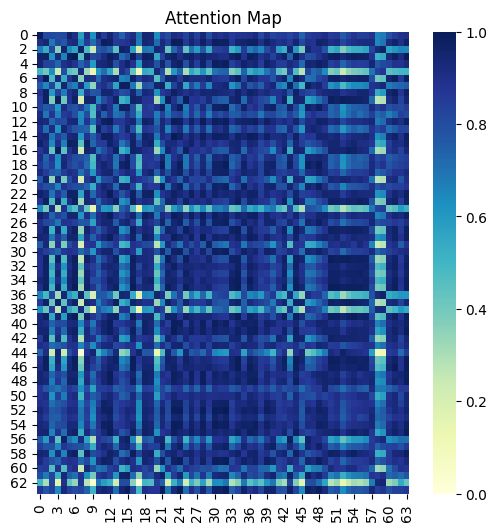

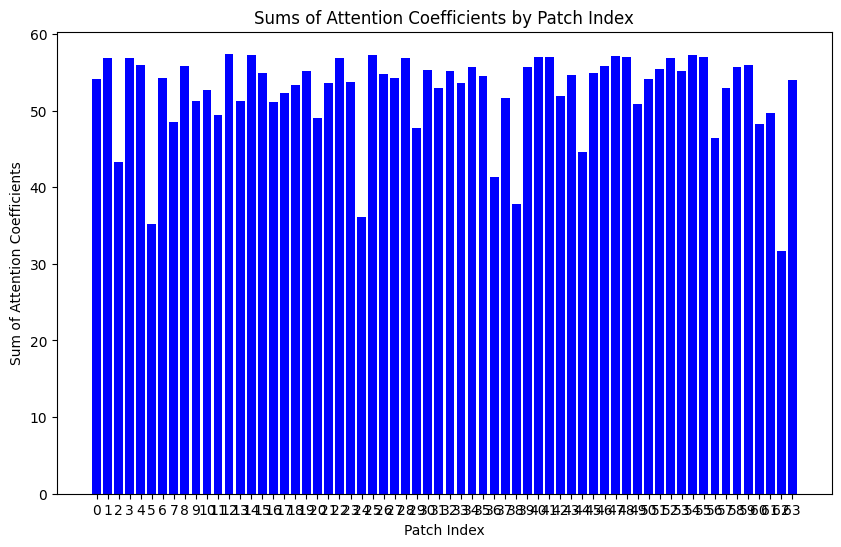


Accuracy: 0.8999999761581421

Loss: 68.84530639648438

AUROC: 0.9625

Precision: 0.9

Recall: 0.9

F1 Score: 0.9

AUPRC: 0.9554093648962576



/tmp/ipykernel_308884/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [31]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


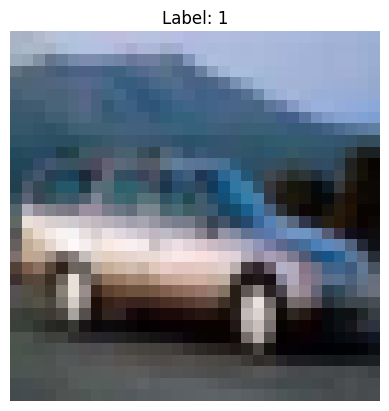

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[4]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[4][0]}')
plt.axis('off')
plt.show()


In [30]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [31]:
single

array([[[179.062, 177.062, 184.66 , ...,  98.915, 100.083,  93.169],
        [194.023, 192.468, 194.006, ...,  95.287,  95.238,  94.928],
        [193.463, 192.762, 195.039, ...,  91.069,  98.792, 102.526],
        ...,
        [ 57.854,  44.854,  49.082, ...,  91.961,  87.548,  84.124],
        [ 28.869,  28.755,  26.858, ...,  78.124,  78.548,  75.146],
        [ 23.445,  26.146,  28.146, ...,  78.146,  74.146,  76.146]]])

In [32]:
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

In [33]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [34]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


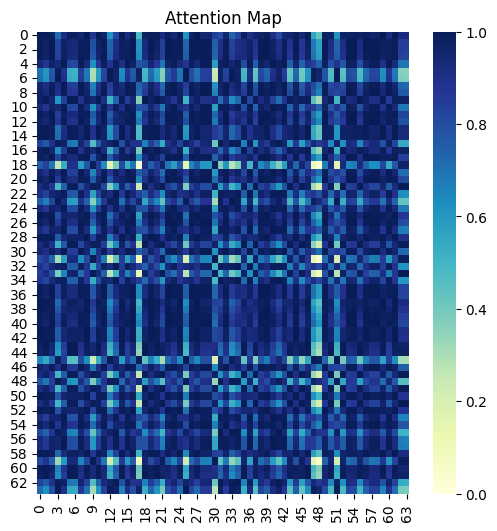

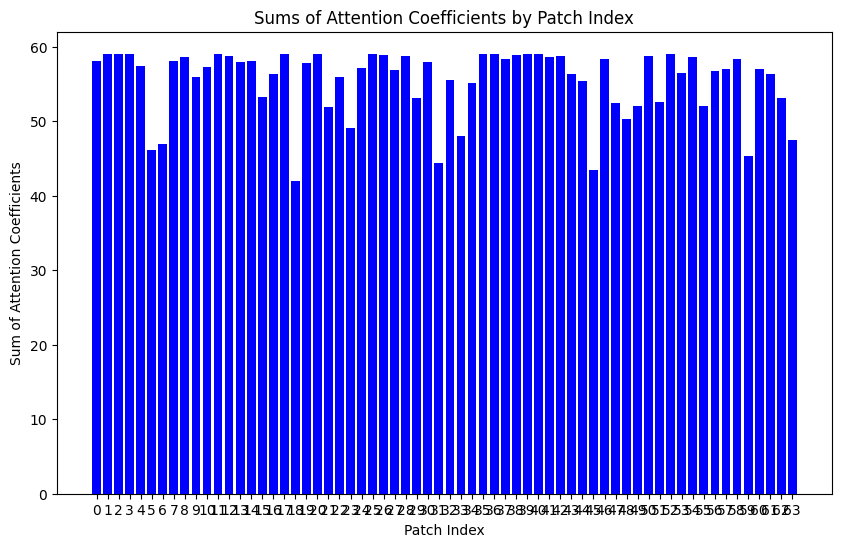

Predicted class for the sample: 1.0
Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


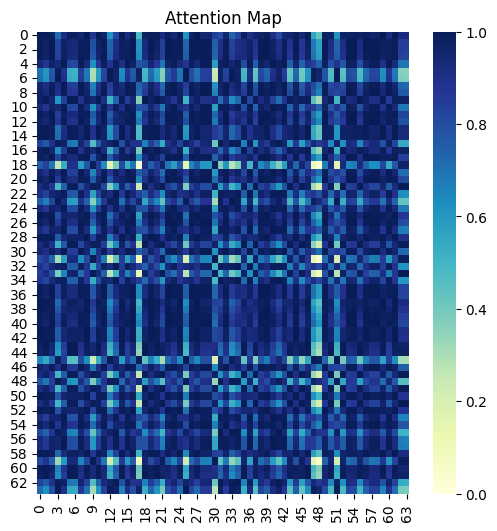

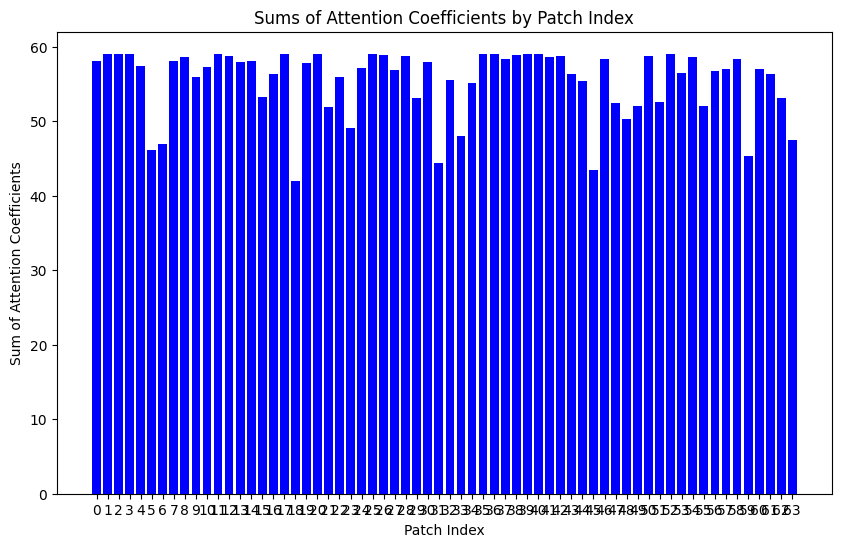

Extracted attention values: tensor([[[0.9977, 0.9988, 0.9877,  ..., 0.9987, 0.9493, 0.9467],
         [0.9968, 0.9808, 1.0000,  ..., 0.9952, 0.8950, 0.8914],
         [0.9960, 0.9791, 1.0000,  ..., 0.9943, 0.8912, 0.8875],
         ...,
         [0.9846, 0.9982, 0.9654,  ..., 0.9875, 0.9773, 0.9755],
         [0.8865, 0.8317, 0.9225,  ..., 0.8786, 0.6781, 0.6730],
         [0.8057, 0.7415, 0.8510,  ..., 0.7962, 0.5775, 0.5724]]])


In [35]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

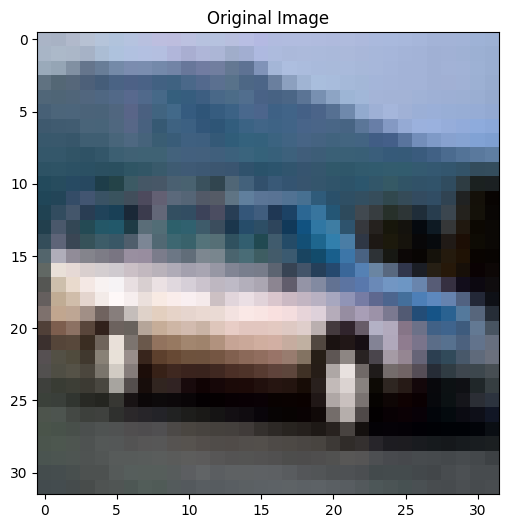

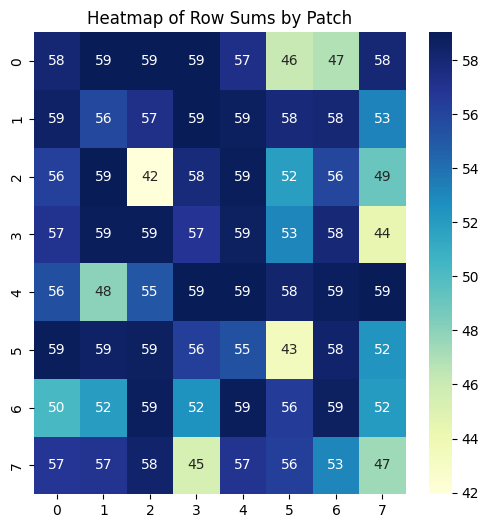

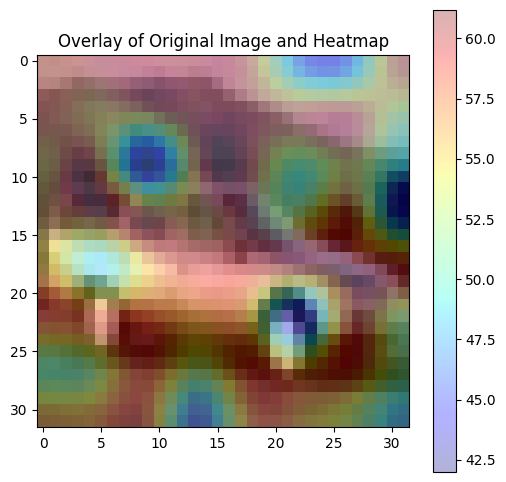

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.3, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[58.063984, 59.032066, 59.03582, 59.017338, 57.32975, 46.169643, 46.861065, 57.99359, 58.530388, 55.853123, 57.24405, 59.015244, 58.757797, 57.89521, 58.031208, 53.21495, 56.294098, 59.03276, 41.93651, 57.794792, 58.947304, 51.86485, 55.909496, 49.107193, 57.081688, 58.942497, 58.872932, 56.888847, 58.687542, 53.02982, 57.938908, 44.345905, 55.55957, 48.011303, 55.104053, 59.01985, 59.016228, 58.261063, 58.81405, 59.035725, 58.967293, 58.558296, 58.699913, 56.319786, 55.409805, 43.420235, 58.356987, 52.373383, 50.236298, 52.02114, 58.777344, 52.491394, 58.941856, 56.457733, 58.637802, 52.067383, 56.77289, 56.96529, 58.363358, 45.35786, 57.029922, 56.30916, 53.03, 47.428307]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


-----------------------------------------